# Inputs

In [1]:
import os
import re

folder_name = '327/Pulse Calibration Redo'
file_names = [file_name for file_name in os.listdir(folder_name) if re.match(r'^\d+_\d+\.csv$', file_name)]

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
# %matplotlib widget

In [3]:
# Fit a decaying exponential to the envelope (no need for peak detection here)
# Model: A * exp(-t / T2star*) + C
def model_exp(t, A, T2star, C):
    return A * np.exp(-t / T2star) + C

# Load data

In [4]:
# Read the data and pulse times from filenames
data = []
pulse_times = []
for file_name in file_names:
    # Assumes the file name format has the pulse time (in us) before 'us'
    pulse_time = int(file_name.split('/')[-1].split('_')[0])
    df = pd.read_csv(os.path.join(folder_name, file_name), header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    df = df[(df['t'] > 0.001) & (df['t'] < 0.004)]
    # df = df[(df['t'] > 0.001)]
    data.append(df)
    pulse_times.append(pulse_time)

# Use sum of squares to reconstruct envelope, and fit envelope

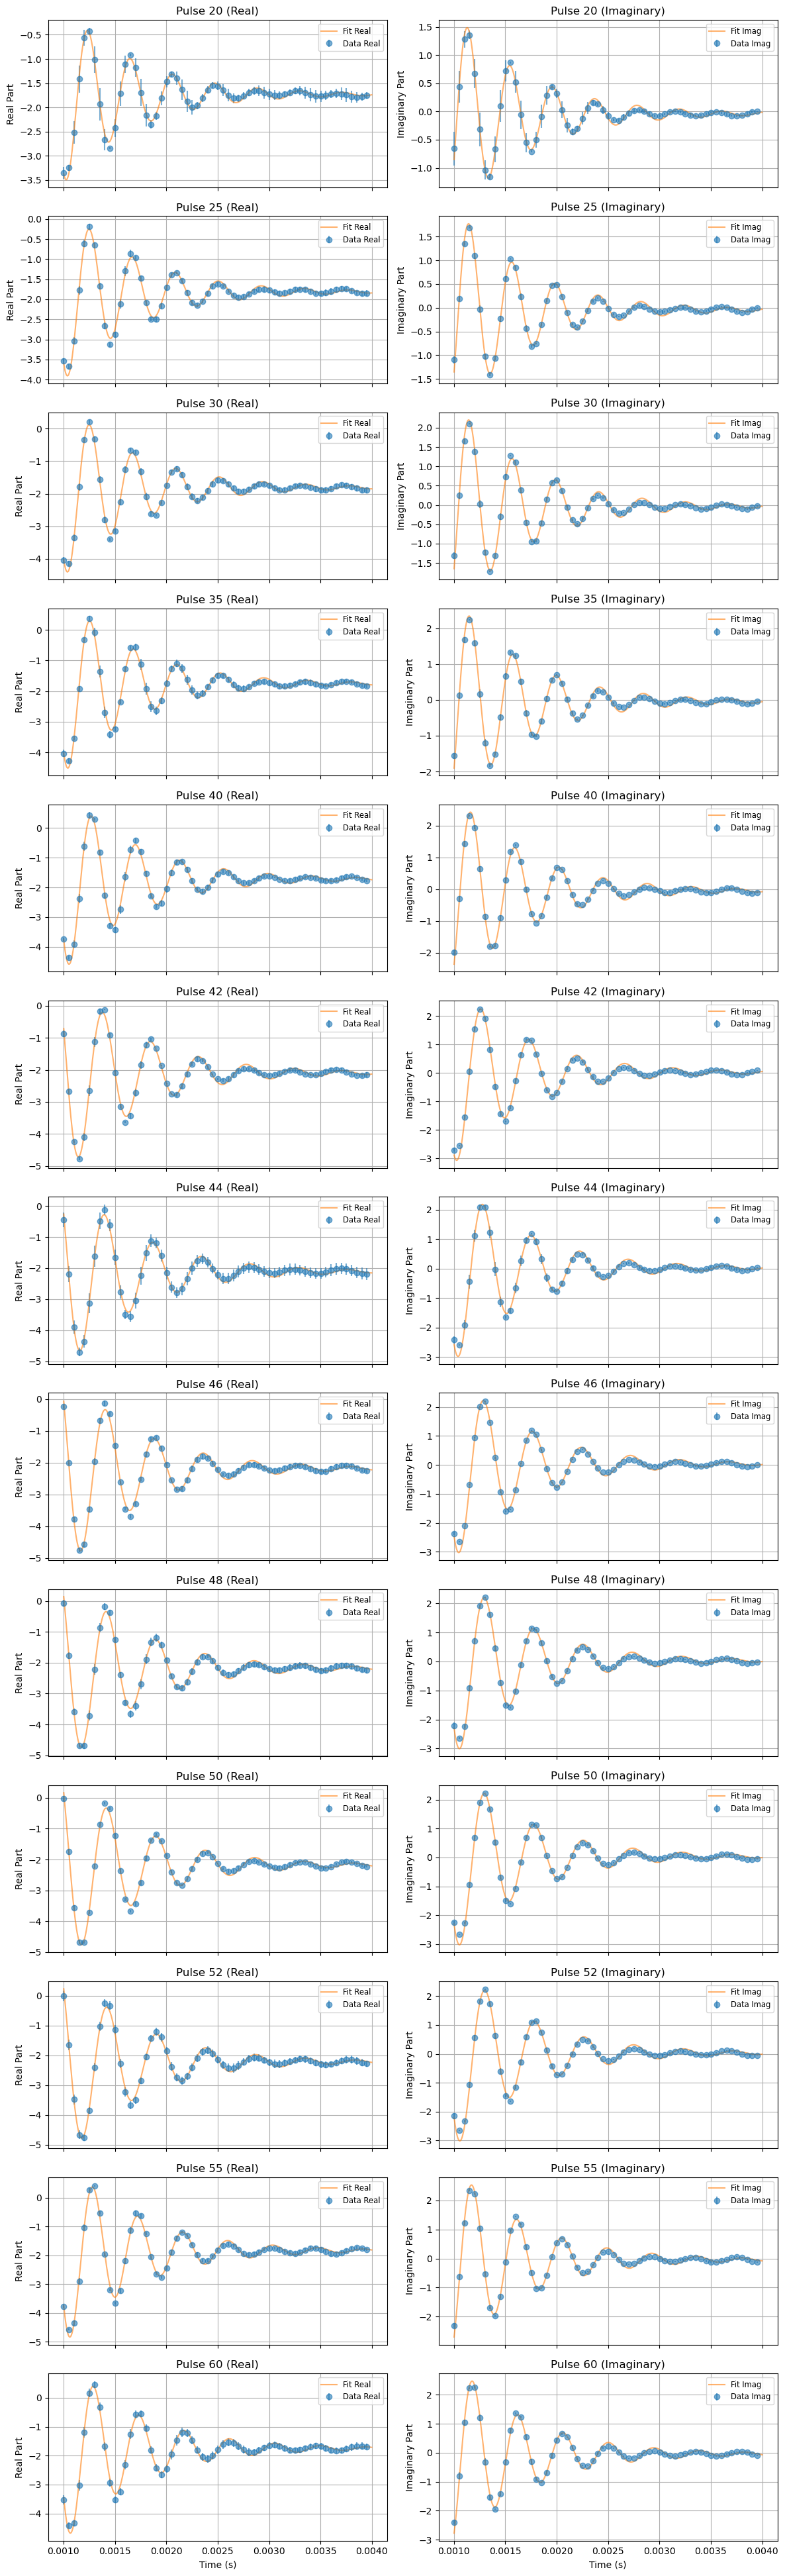

Global T2star: 0.7110 ± 0.0007 ms


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt

# Define the complex exponential model with frequency.
def model_complex(t, A, T2star, f, phi, C_real, C_imag):
    """
    Returns the complex signal:
      A * exp(-t/T2star) * exp(i*(2*pi*f*t + phi)) + (C_real + i*C_imag)
    """
    return A * np.exp(-t / T2star) * np.exp(1j * (2 * np.pi * f * t + phi)) + (C_real + 1j * C_imag)

# Group the data by pulse time.
grouped_data = defaultdict(list)
for df, pulse_time in zip(data, pulse_times):
    grouped_data[pulse_time].append(df)

# Process each group to compute the averaged (complex) signal and its standard deviation.
group_data_list = []
# Sort the groups by pulse time so the order is fixed.
pulse_times_sorted = sorted(grouped_data.keys())
for pulse_time in pulse_times_sorted:
    dfs = grouped_data[pulse_time]
    signals = []   # will store the complex signal for each trace in this group
    t_common = None
    for df in dfs:
        t = df['t'].values
        if t_common is None:
            t_common = t  # assume all traces in the group share the same time array
        # Create the complex signal (using CH1 as real and CH2 as imaginary).
        signal = df['CH1'].values + 1j * df['CH2'].values
        # Smooth the signal using a lowpass Butterworth filter.
        b, a = butter(3, 5000, btype="lowpass", fs=500000)
        signal = filtfilt(b, a, signal)
        signals.append(signal)
    signals = np.array(signals)
    # Compute the average and standard deviation (separately for real and imag).
    avg_real = np.mean(np.real(signals), axis=0)
    avg_imag = np.mean(np.imag(signals), axis=0)
    std_real = np.std(np.real(signals), axis=0, ddof=1) if signals.shape[0] > 1 else np.zeros_like(avg_real)
    std_imag = np.std(np.imag(signals), axis=0, ddof=1) if signals.shape[0] > 1 else np.zeros_like(avg_imag)
    avg_signal = avg_real + 1j * avg_imag
    group_data_list.append({
       'pulse_time': pulse_time,
       't': t_common,
       'avg_signal': avg_signal,
       'std_real': std_real,
       'std_imag': std_imag
    })

# Construct the composite ydata vector for simultaneous fitting.
# For each group, we stack the averaged real and imaginary parts.
ydata_list = []
for group in group_data_list:
    y_group = np.concatenate((group['avg_signal'].real, group['avg_signal'].imag))
    ydata_list.append(y_group)
ydata_sim = np.concatenate(ydata_list)

# We'll use the list of time arrays (one per group) in the simultaneous model.
# This is a global list used by the model function.
group_t_list = [group['t'] for group in group_data_list]

# Define the composite model function.
# The parameter vector is organized as follows:
#   For each group i (of N groups): [A_i, f_i, phi_i, C_real_i, C_imag_i]
#   Followed by one global parameter: T2star
# So the total number of parameters is 5*N + 1.
def model_simultaneous(dummy_x, *params):
    N = len(group_t_list)
    T2star = params[-1]
    y_model = []
    for i in range(N):
        A    = params[5*i + 0]
        f    = params[5*i + 1]
        phi  = params[5*i + 2]
        C_re = params[5*i + 3]
        C_im = params[5*i + 4]
        t_arr = group_t_list[i]
        model_vals = model_complex(t_arr, A, T2star, f, phi, C_re, C_im)
        # Stack real and imaginary parts as done in the individual fits.
        y_model.append(np.concatenate((model_vals.real, model_vals.imag)))
    return np.concatenate(y_model)

# Build an initial guess (p0) for the parameters.
# For each group, we guess:
#   A: 10 (or you could use np.abs(avg_signal[0]) if preferred)
#   f: 2000 Hz,
#   phi: phase of the first point of the averaged signal,
#   C_real: 0, and C_imag: 0.
# Then append one global guess for T2star (e.g., 0.001 s).
p0 = []
for group in group_data_list:
    avg_signal = group['avg_signal']
    p0.extend([10, 2000, np.angle(avg_signal[0]), 0, 0])
p0.append(0.001)

# Perform the simultaneous fit.
# We pass a dummy xdata (None) since our model function uses the global group_t_list.
try:
    popt, pcov = curve_fit(model_simultaneous, None, ydata_sim, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    fit_success = True
except RuntimeError:
    popt = [np.nan] * (len(p0))
    perr = [np.nan] * (len(p0))
    fit_success = False

# Build a list of fit results for each group (for later plotting).
all_fits = []
N = len(group_t_list)
global_T2star = popt[-1]
for i, group in enumerate(group_data_list):
    # Extract the parameters for group i.
    A    = popt[5*i + 0]
    f    = popt[5*i + 1]
    phi  = popt[5*i + 2]
    C_re = popt[5*i + 3]
    C_im = popt[5*i + 4]
    t_arr = group['t']
    fitted_curve = model_complex(t_arr, A, global_T2star, f, phi, C_re, C_im)
    all_fits.append({
        'pulse_time': group['pulse_time'],
        't': t_arr,
        'avg_real': np.real(group['avg_signal']),
        'avg_imag': np.imag(group['avg_signal']),
        'std_real': group['std_real'],
        'std_imag': group['std_imag'],
        'fit_real': fitted_curve.real,
        'fit_imag': fitted_curve.imag,
        # For convenience we store each group’s parameters along with the shared T2star.
        'popt': popt[5*i:5*i+5] + [global_T2star],
        'perr': perr[5*i:5*i+5].tolist() + [perr[-1]],
        'fit_success': fit_success
    })

# Plot the fits versus the averaged data (with error bars) for each pulse time.
num_fits = len(all_fits)
fig, axs = plt.subplots(nrows=num_fits, ncols=2, figsize=(12, 3*num_fits), sharex=True)
if num_fits == 1:
    axs = np.array([axs])
for i, fit in enumerate(all_fits):
    DOWNSAMPLE_RATE = 25
    # Real part subplot.
    axs[i, 0].errorbar(fit['t'][::DOWNSAMPLE_RATE], fit['avg_real'][::DOWNSAMPLE_RATE],
                        yerr=fit['std_real'][::DOWNSAMPLE_RATE], fmt='o', alpha=0.6, label='Data Real')
    if fit['fit_success']:
        axs[i, 0].plot(fit['t'], fit['fit_real'], '-', alpha=0.6, label='Fit Real')
    else:
        axs[i, 0].text(0.05, 0.9, 'Fit Failed', transform=axs[i, 0].transAxes, color='red')
    axs[i, 0].set_ylabel('Real Part')
    axs[i, 0].set_title(f'Pulse {fit["pulse_time"]} (Real)')
    axs[i, 0].legend(fontsize='small')
    axs[i, 0].grid(True)
    
    # Imaginary part subplot.
    axs[i, 1].errorbar(fit['t'][::DOWNSAMPLE_RATE], fit['avg_imag'][::DOWNSAMPLE_RATE],
                        yerr=fit['std_imag'][::DOWNSAMPLE_RATE], fmt='o', alpha=0.6, label='Data Imag')
    if fit['fit_success']:
        axs[i, 1].plot(fit['t'], fit['fit_imag'], '-', alpha=0.6, label='Fit Imag')
    else:
        axs[i, 1].text(0.05, 0.9, 'Fit Failed', transform=axs[i, 1].transAxes, color='red')
    axs[i, 1].set_ylabel('Imaginary Part')
    axs[i, 1].set_title(f'Pulse {fit["pulse_time"]} (Imaginary)')
    axs[i, 1].legend(fontsize='small')
    axs[i, 1].grid(True)

# Label x-axis on the bottom row.
for ax in axs[-1, :]:
    ax.set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Build a summary DataFrame for the amplitude A from each pulse time group.
results_list = []
for fit in all_fits:
    if fit['fit_success']:
        A = fit['popt'][0]
        A_err = fit['perr'][0]
        results_list.append({'Pulse Time (us)': fit['pulse_time'], 'A': A, 'A_err': A_err})
results_df = pd.DataFrame(results_list).sort_values('Pulse Time (us)')

# Print global T2star and its uncertainty.
if fit_success:
    print(f"Global T2star: {global_T2star*1e3:.4f} ± {perr[-1]*1e3:.4f} ms")

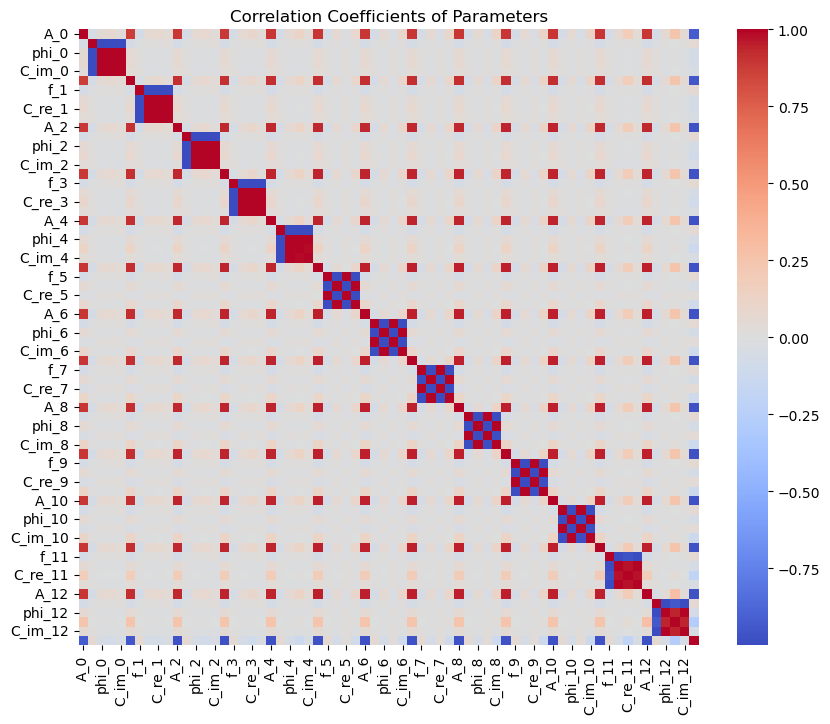

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot heatmap of the correlation coefficients between the parameters.
# Create a DataFrame from the covariance matrix.
cov_matrix = np.array(pcov)
param_names = []
for i in range(N):
    param_names.extend([f'A_{i}', f'f_{i}', f'phi_{i}', f'C_re_{i}', f'C_im_{i}'])
param_names.append('T2star')
cov_df = pd.DataFrame(cov_matrix, index=param_names, columns=param_names)
# Compute the correlation matrix.
corr_matrix = cov_df.corr()
corr_df = pd.DataFrame(corr_matrix, index=param_names, columns=param_names)
# Plot the heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Coefficients of Parameters')
plt.show()

In [19]:
corr_df

A_0       f_0     phi_0    C_re_0    C_im_0       A_1       f_1  \
A_0      1.000000 -0.052806  0.052769  0.063489  0.026609  0.868943 -0.058556   
f_0     -0.052806  1.000000 -1.000000 -0.999519 -0.998850 -0.058737 -0.015114   
phi_0    0.052769 -1.000000  1.000000  0.999520  0.998852  0.058701  0.015104   
C_re_0   0.063489 -0.999519  0.999520  1.000000  0.997958  0.065010  0.014011   
C_im_0   0.026609 -0.998850  0.998852  0.997958  1.000000  0.041496  0.015642   
...           ...       ...       ...       ...       ...       ...       ...   
f_12    -0.058544 -0.015114  0.015104  0.014011  0.015642 -0.058722 -0.015113   
phi_12   0.058516  0.015103 -0.015094 -0.014001 -0.015632  0.058695  0.015103   
C_re_12  0.245718 -0.002623  0.002621  0.004856 -0.001705  0.250994 -0.002622   
C_im_12  0.049299  0.015008 -0.014999 -0.013994 -0.015386  0.049293  0.015008   
T2star  -0.923120  0.060155 -0.060118 -0.066994 -0.041714 -0.946388  0.060152   

            phi_1    C_re_1    C_im_1  ...      f_11    phi_11   C_re_11  \
A_0      0.058520  0.073085  0.041863  ... -0.058543  0.058515  0.183799   
f_0      0.015104  0.013251  0.015628  ... -0.015114  0.015103  0.003581   
phi_0   -0.015095 -0.013243 -0.015618  ...  0.015104 -0.015094 -0.003578   
C_re_0  -0.014002 -0.012078 -0.014663  ...  0.014011 -0.014001 -0.001707   
C_im_0  -0.015632 -0.014090 -0.015853  ...  0.015642 -0.015631 -0.006644   
...           ...       ...       ...  ...       ...       ...       ...   
f_12     0.015104  0.013251  0.015627  ... -0.015113  0.015102  0.003582   
phi_12  -0.015093 -0.013241 -0.015616  ...  0.015102 -0.015092 -0.003577   
C_re_12  0.002621  0.007403 -0.001660  ... -0.002620  0.002621  0.040554   
C_im_12 -0.014998 -0.013329 -0.015372  ...  0.015007 -0.014997 -0.004897   
T2star  -0.060115 -0.076325 -0.041901  ...  0.060138 -0.060110 -0.198440   

          C_im_11      A_12      f_12    phi_12   C_re_12   C_im_12    T2star  
A_0      0.046060  0.895547 -0.058544  0.058516  0.245718  0.049299 -0.923120  
f_0      0.015209 -0.058641 -0.015114  0.015103 -0.002623  0.015008  0.060155  
phi_0   -0.015199  0.058605  0.015104 -0.015094  0.002621 -0.014999 -0.060118  
C_re_0  -0.014218  0.065174  0.014011 -0.014001  0.004856 -0.013994 -0.066994  
C_im_0  -0.015524  0.040936  0.015642 -0.015632 -0.001705 -0.015386 -0.041714  
...           ...       ...       ...       ...       ...       ...       ...  
f_12     0.015208 -0.046842  1.000000 -1.000000 -0.943514 -0.999286  0.060139  
phi_12  -0.015197  0.046815 -1.000000  1.000000  0.943513  0.999288 -0.060111  
C_re_12 -0.000325  0.282028 -0.943514  0.943513  1.000000  0.938852 -0.267039  
C_im_12 -0.015006  0.034324 -0.999286  0.999288  0.938852  1.000000 -0.049991  
T2star  -0.046445 -0.975006  0.060139 -0.060111 -0.267039 -0.049991  1.000000  

[66 rows x 66 columns]

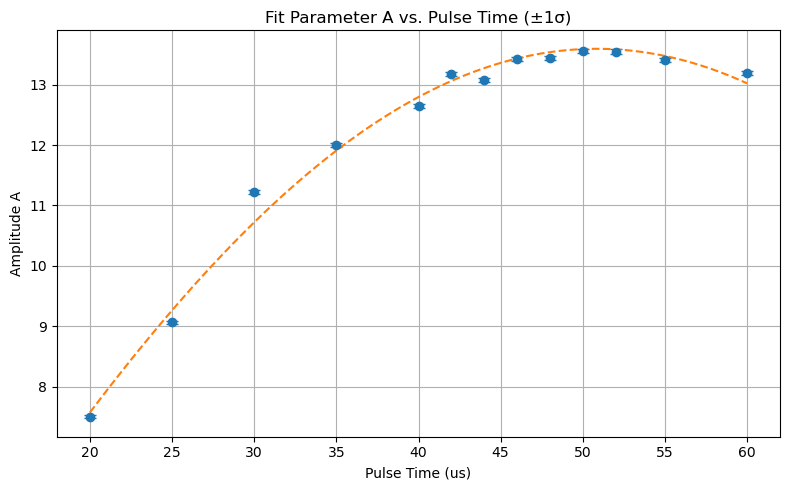

In [11]:
def abs_sinusoid(x, a, f, phi):
    return a * np.abs(np.sin(2 * np.pi * f * x + phi))

# Use an initial guess, e.g., scaling from the max A, a small frequency, and zero phase.
p0_sin = [np.max(results_df['A']), 1e-3, np.pi/2]
popt_sin, pcov_sin = curve_fit(
    abs_sinusoid,
    results_df['Pulse Time (us)'],
    results_df['A'],
    sigma=results_df['A_err'],
    absolute_sigma=True,
    p0=p0_sin
)

# Plot A vs. Pulse Time with error bars from the fit uncertainties.
plt.figure(figsize=(8, 5))
plt.errorbar(results_df['Pulse Time (us)'], results_df['A'],
             yerr=results_df['A_err'], fmt='o', capsize=4)
x_fit = np.linspace(results_df['Pulse Time (us)'].min(), results_df['Pulse Time (us)'].max(), 100)
y_fit = abs_sinusoid(x_fit, *popt_sin)
plt.plot(x_fit, y_fit, '--', label='Absolute Sinusoid Fit')
plt.xlabel('Pulse Time (us)')
plt.ylabel('Amplitude A')
plt.title('Fit Parameter A vs. Pulse Time (±1σ)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Find maximum of the absolute sinusoid fit.
def find_max_abs_sinusoid(popt, x_fit):
    a, f, phi = popt
    # Find the maximum of the absolute sinusoid.
    max_x = (np.pi/2 - phi) / (2 * np.pi * f)
    max_y = abs_sinusoid(max_x, a, f, phi)
    return max_x, max_y
max_x, max_y = find_max_abs_sinusoid(popt_sin, x_fit)
print(f"Max x (Pulse Time): {max_x:.4f} us")
print(f"Max y (Amplitude): {max_y:.4f}")

Max x (Pulse Time): 50.8369 us
Max y (Amplitude): 13.5939


# Use Hilbert transform to reconstruct envelope, then fit to decaying exponential (NOTE: doesn't work well)

In [6]:
PAD_SIZE = 1000
def fit_decay_with_envelope(df, channel='CH1', prominence=0.2, min_distance=100):
    t = df['t'].values
    signal_raw = df[channel].values
    
    # Compute the analytic signal using the Hilbert transform
    signal_padded = np.pad(signal_raw, (PAD_SIZE, PAD_SIZE), mode="reflect")
    signal_padded = gaussian_filter1d(signal_padded, sigma=10)  # Smoothing to suppress small oscillations
    analytic_signal_padded = hilbert(signal_padded)
    analytic_signal = analytic_signal_padded[PAD_SIZE:-PAD_SIZE]  # Remove padding
    envelope = np.abs(analytic_signal)  # Extract the envelope (magnitude of analytic signal)
    envelope = gaussian_filter1d(envelope, sigma=10)  # Smoothing to suppress small oscillations
    
    # Initial guess for parameters A, T2*, and C (use the first value of the envelope as A, and its decay time)
    p0 = [envelope[0], (t.max() - t.min()) / 2.0, np.min(envelope)]
    popt, _ = curve_fit(model_exp, t, envelope, p0=p0)

    return popt, envelope

    Dataset  Pulse Time (us)  Real_T2star  Imag_T2star
0         1               42     0.002312     0.000890
1         2               40     0.001052     0.002012
2         3               25     0.001022     0.002262
3         4               60     0.001122     0.001423
4         5               44     0.002719     0.000961
..      ...              ...          ...          ...
60       61               55     0.001018     0.001569
61       62               30     0.000986     0.002168
62       63               48     0.002348     0.000989
63       64               55     0.001036     0.001643
64       65               55     0.001127     0.001646

[65 rows x 4 columns]


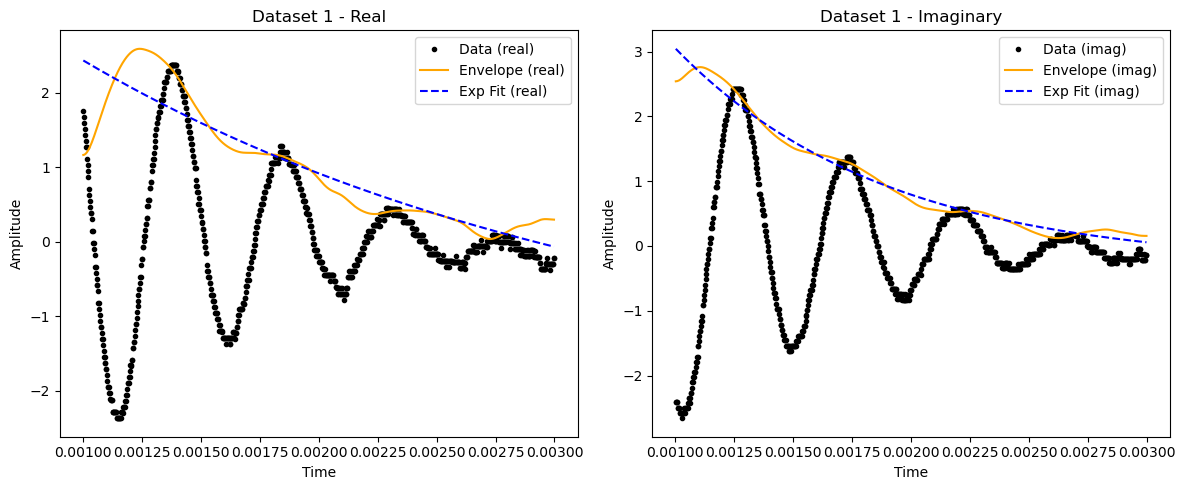

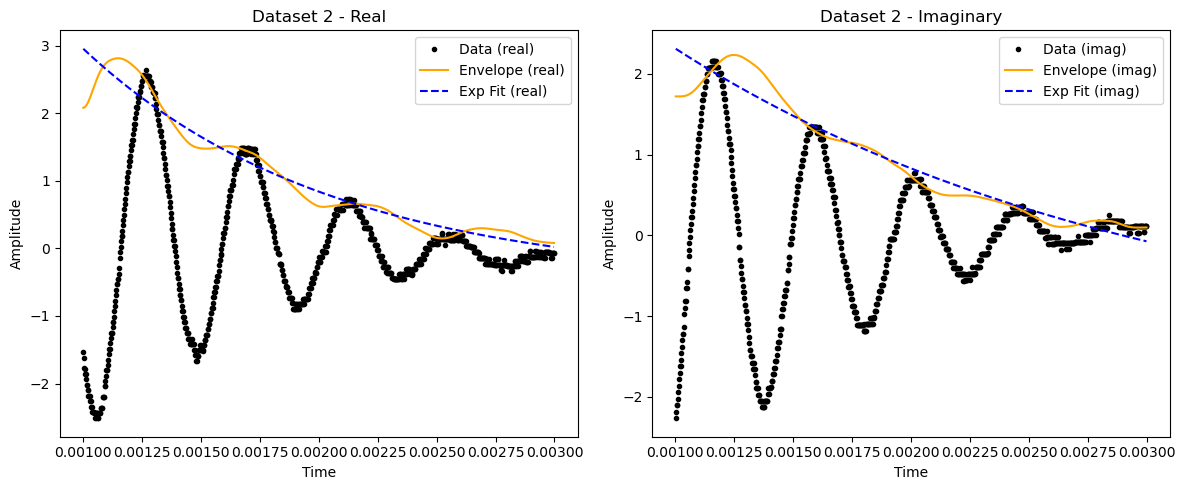

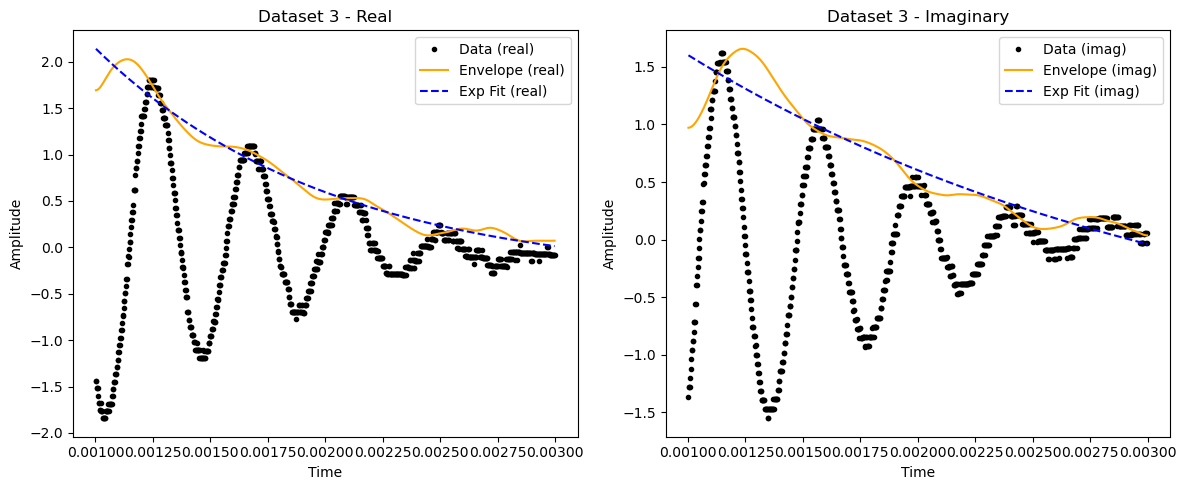

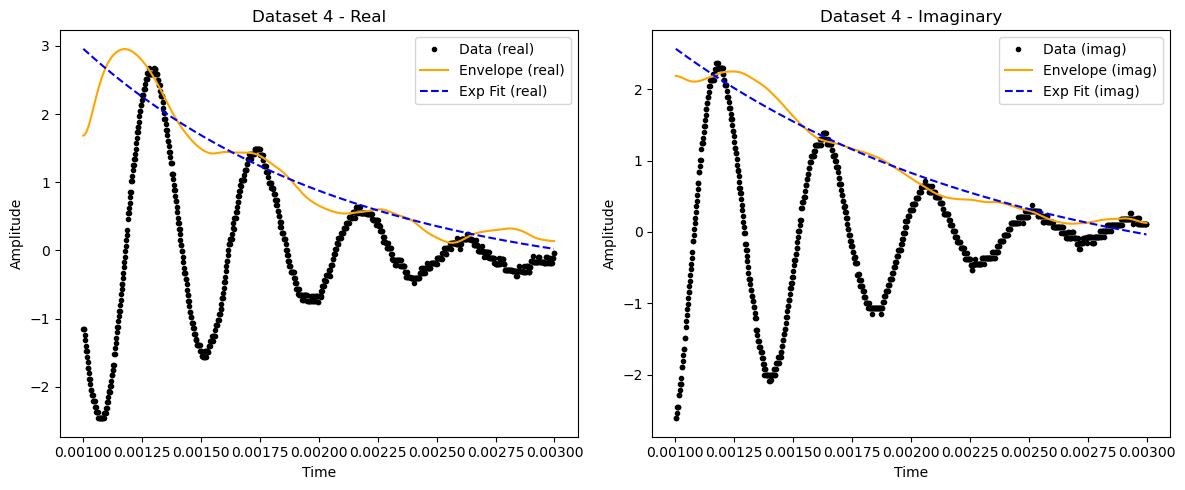

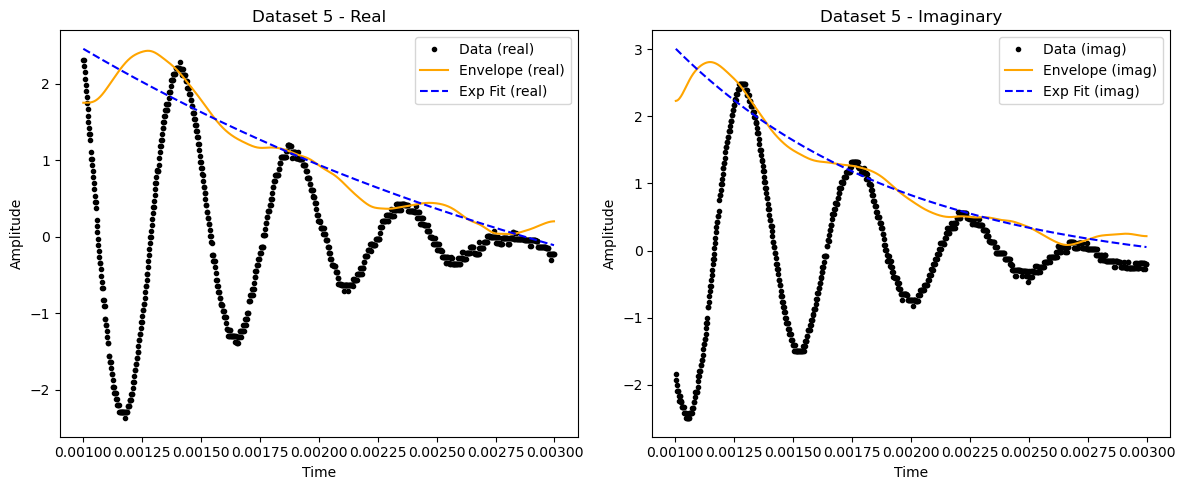

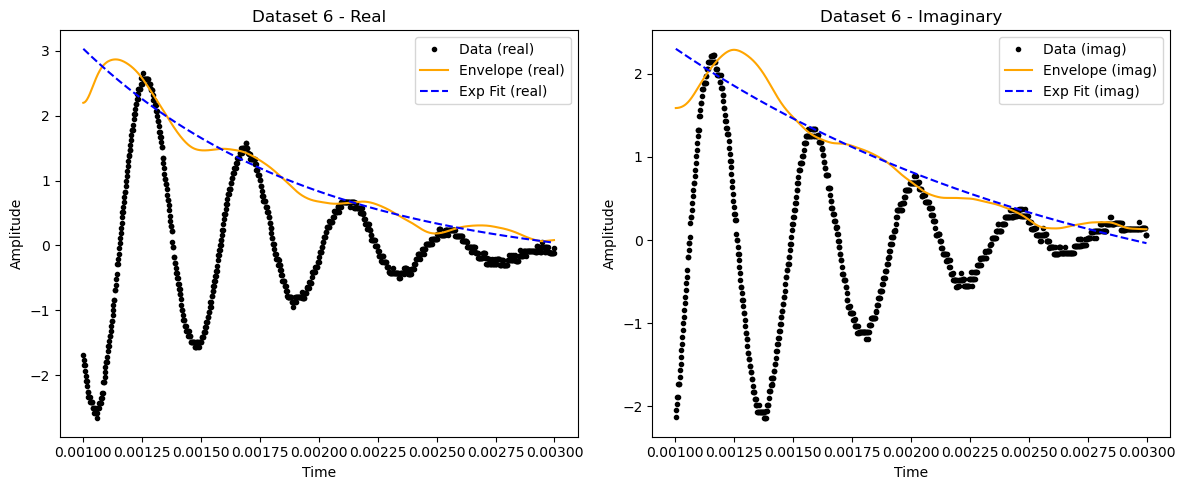

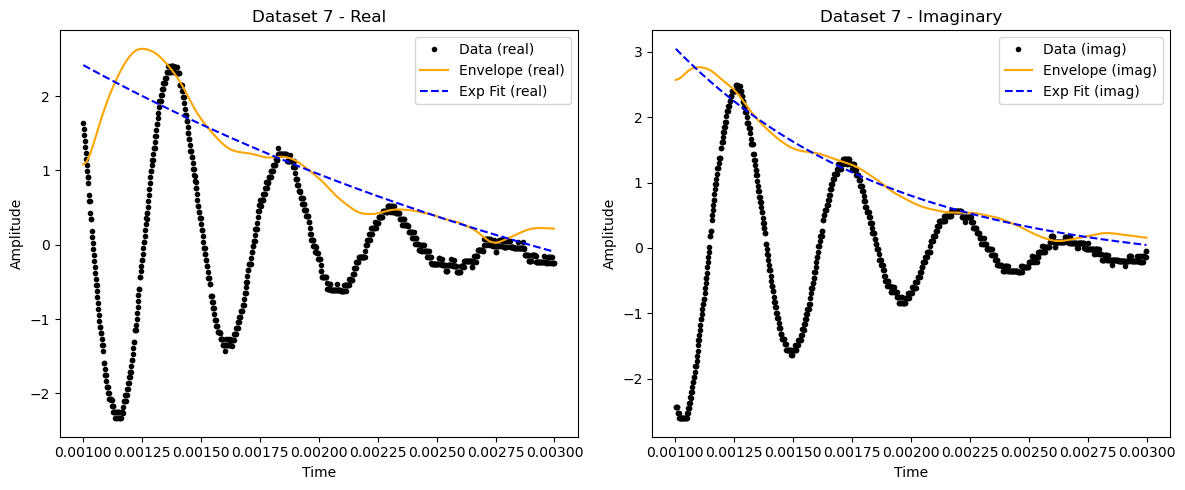

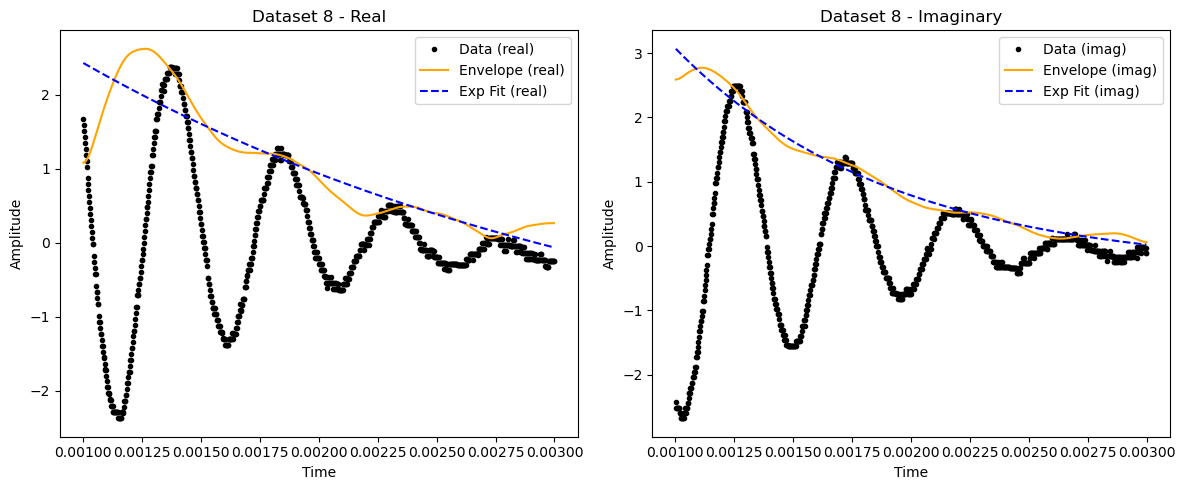

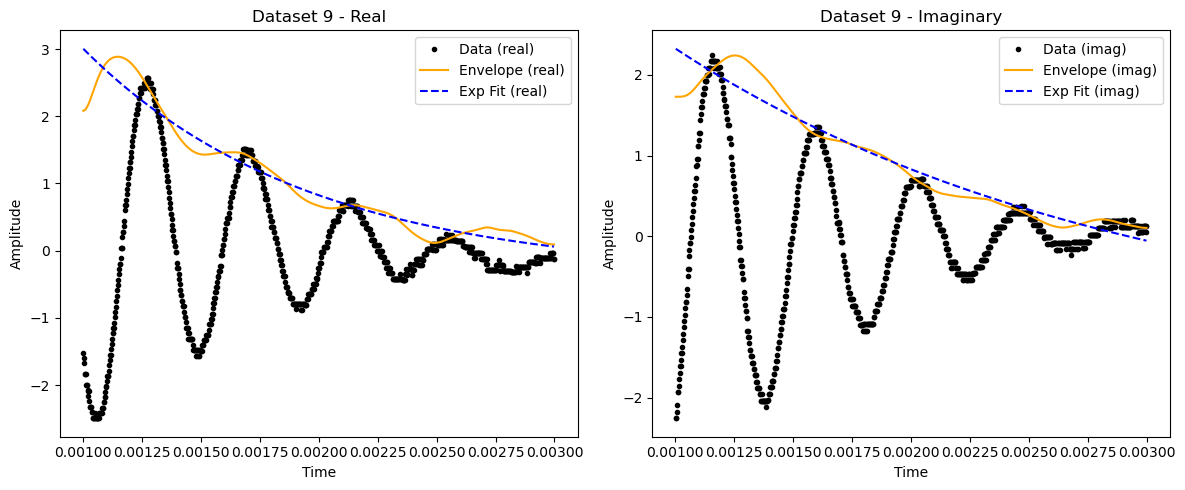

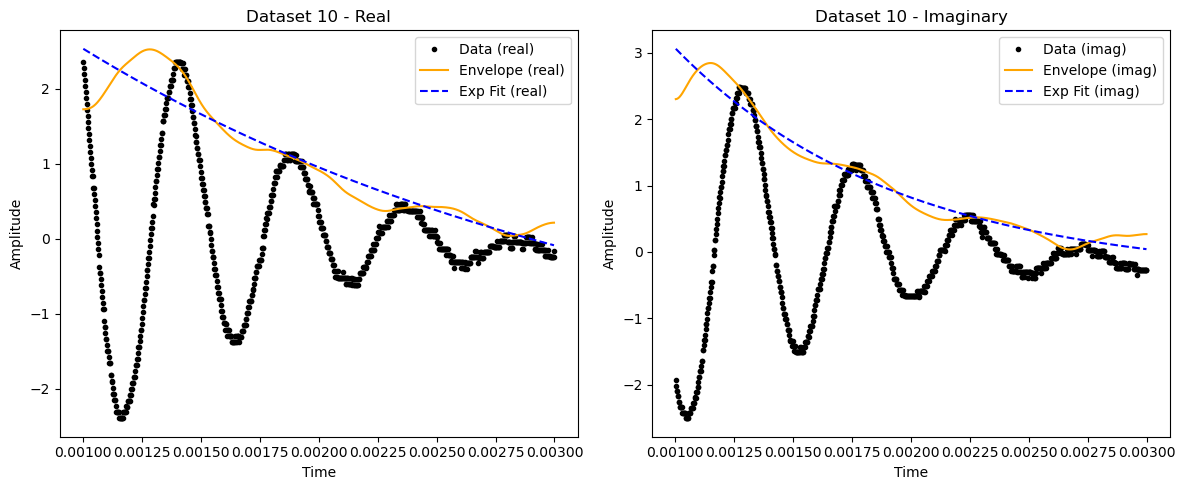

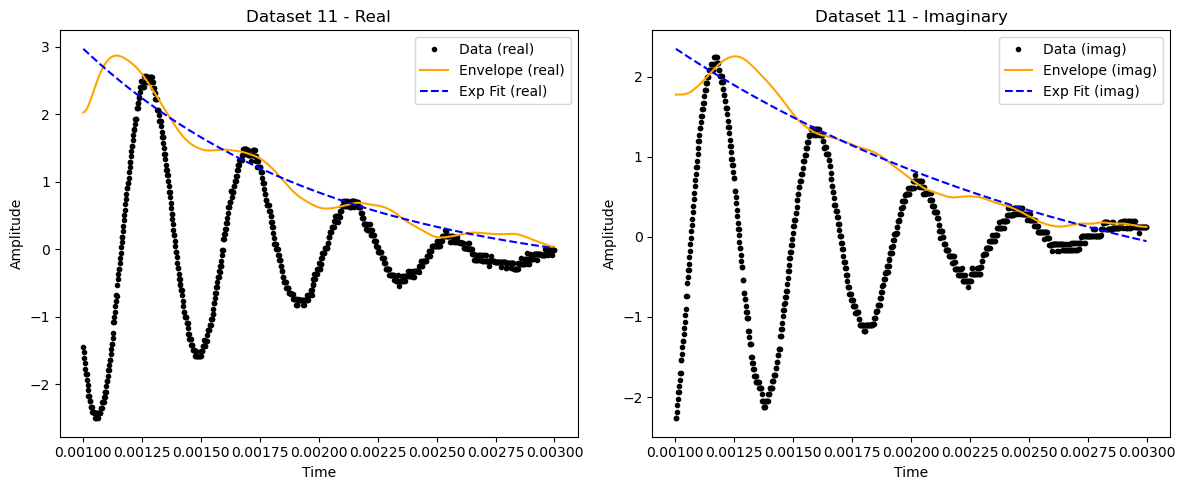

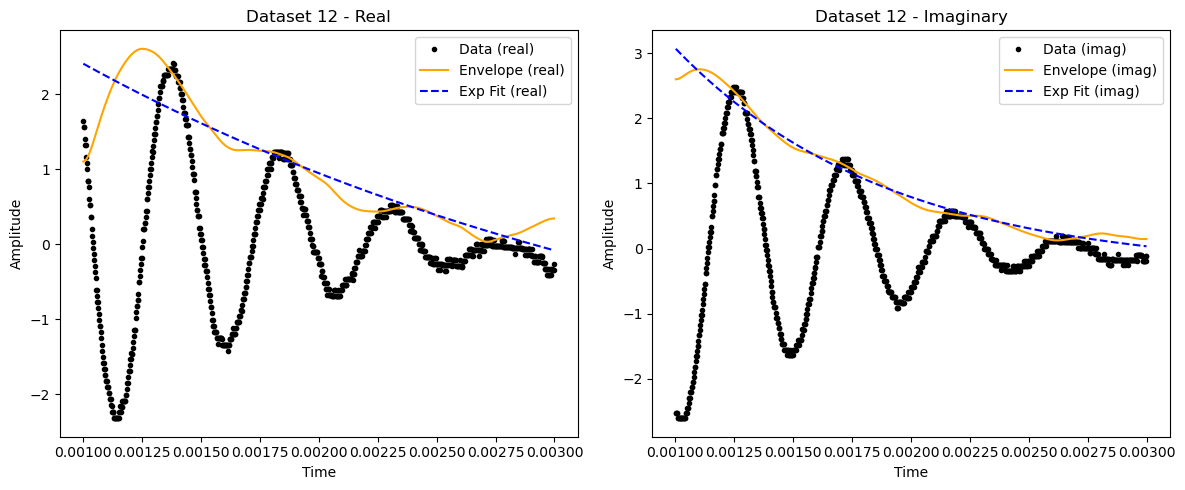

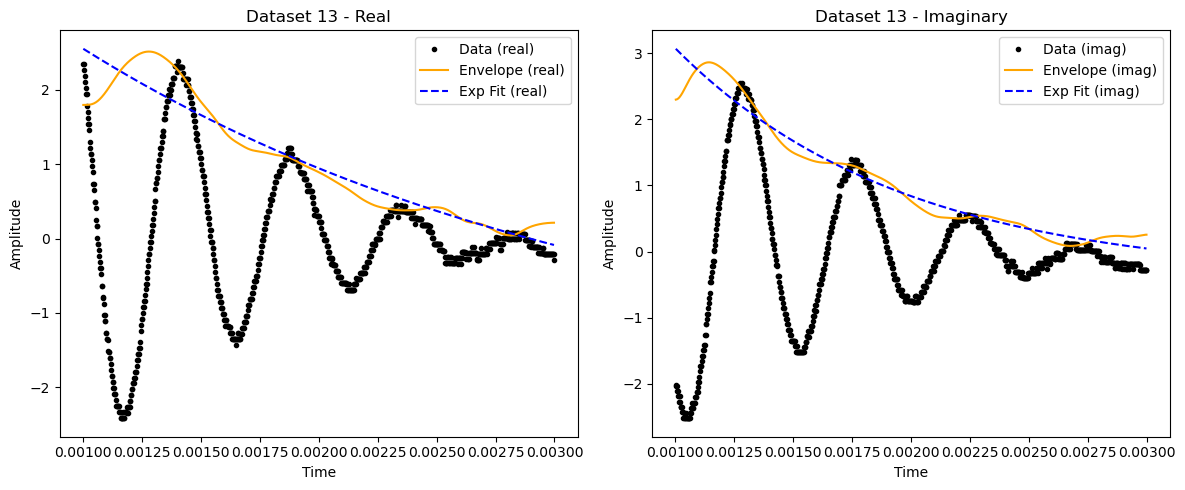

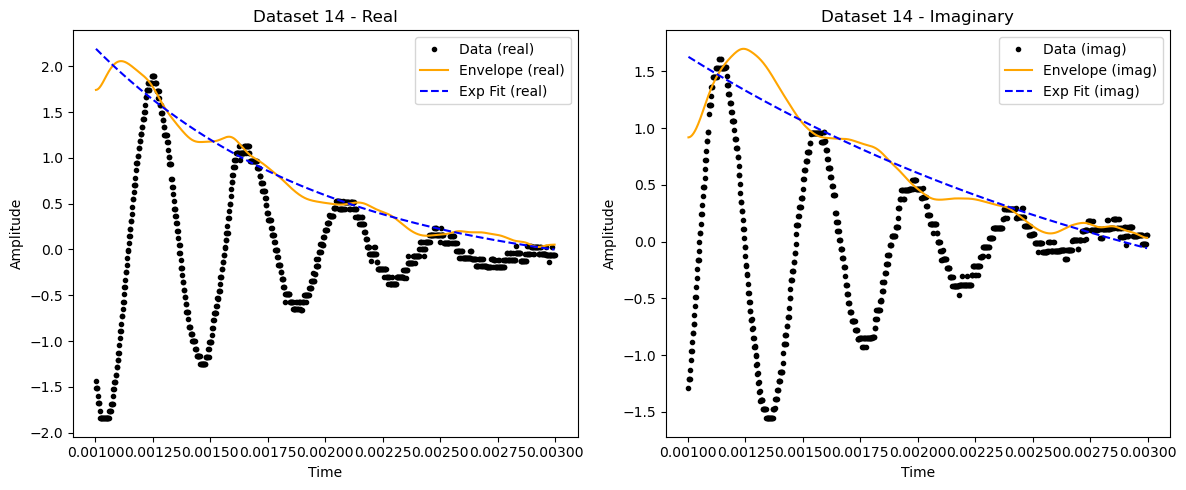

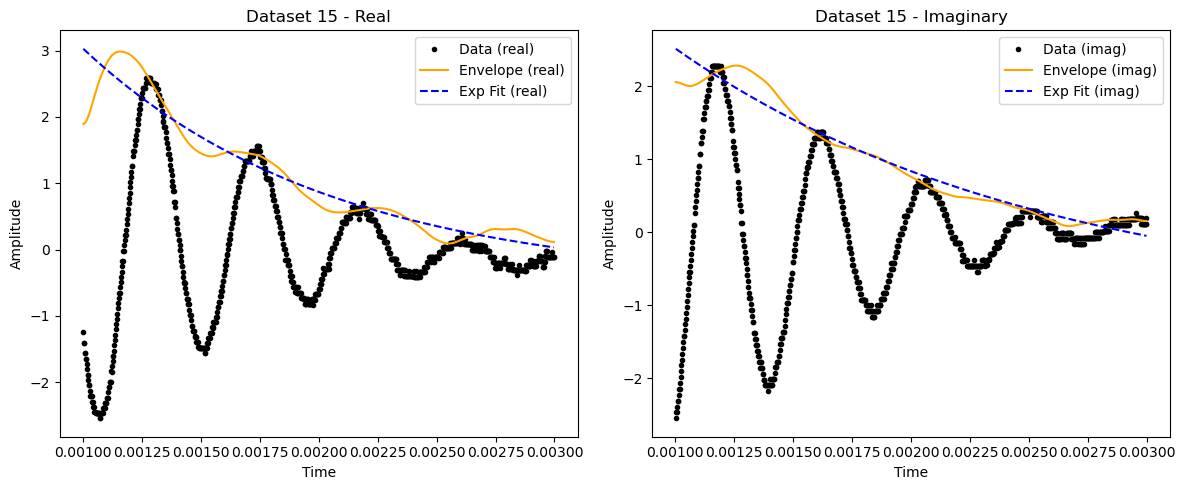

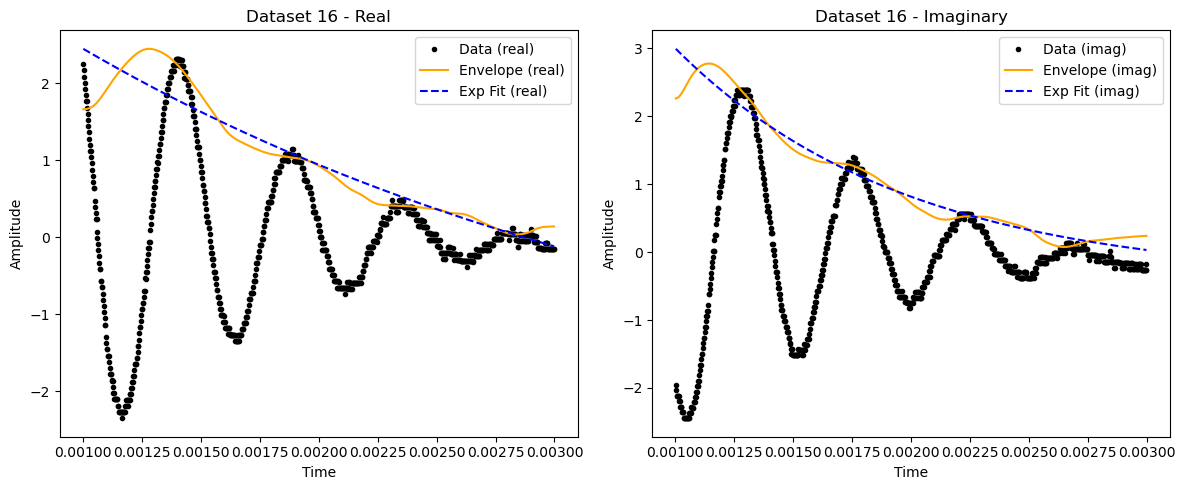

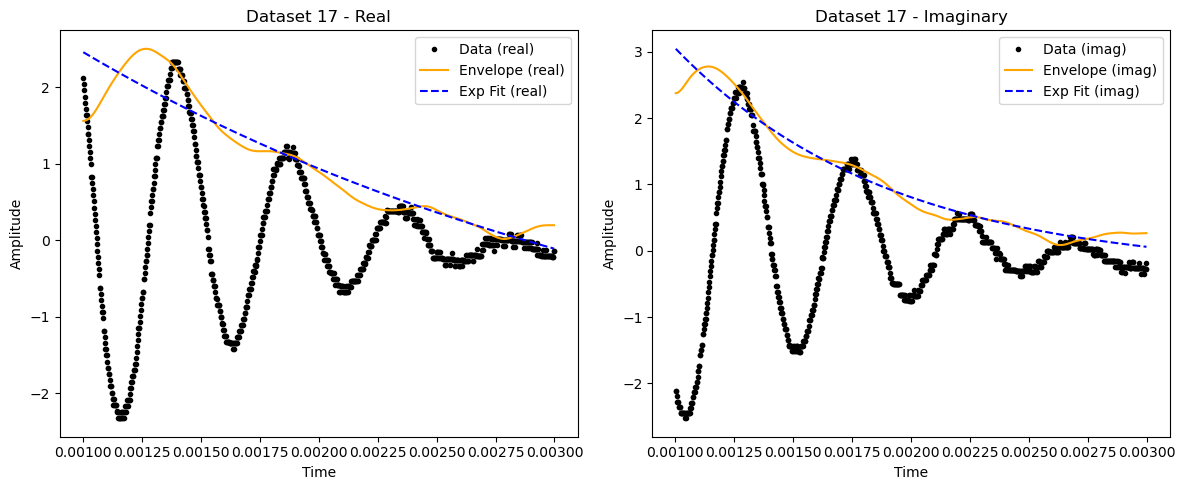

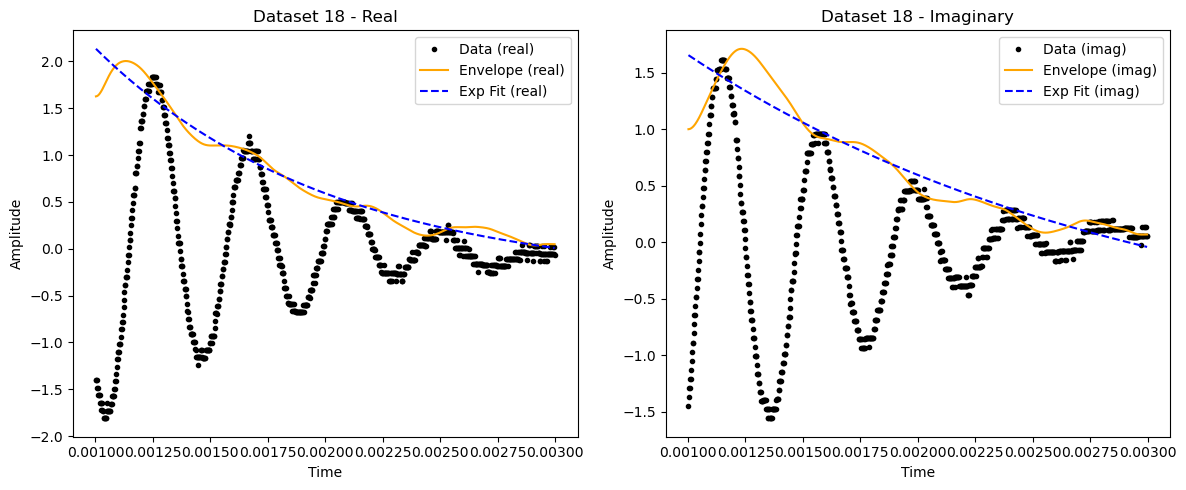

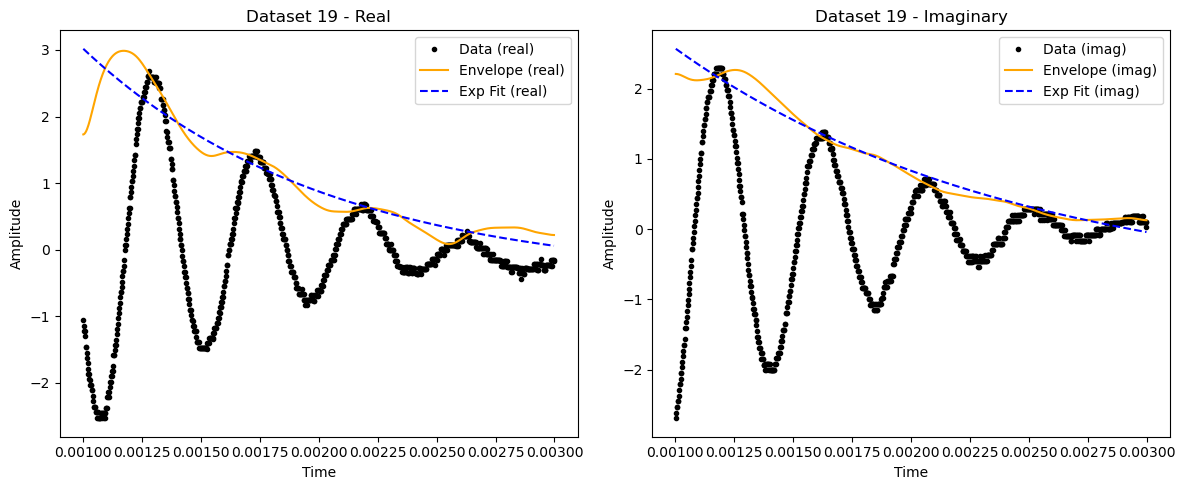

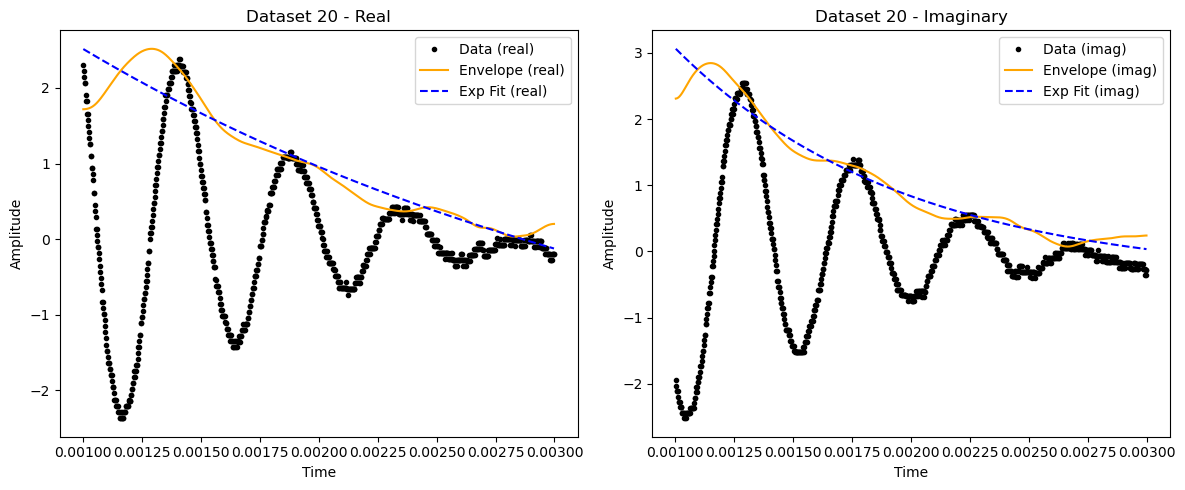

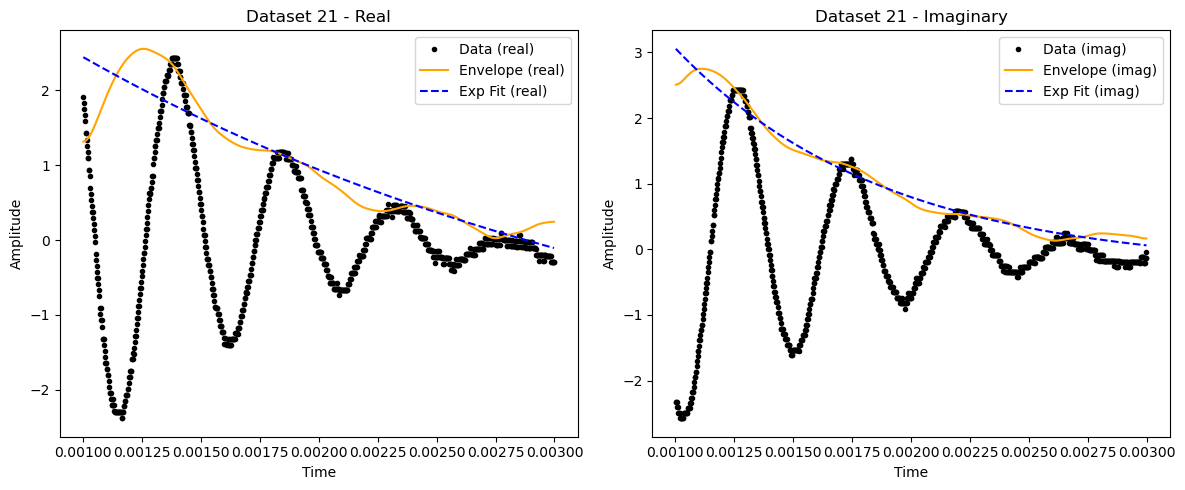

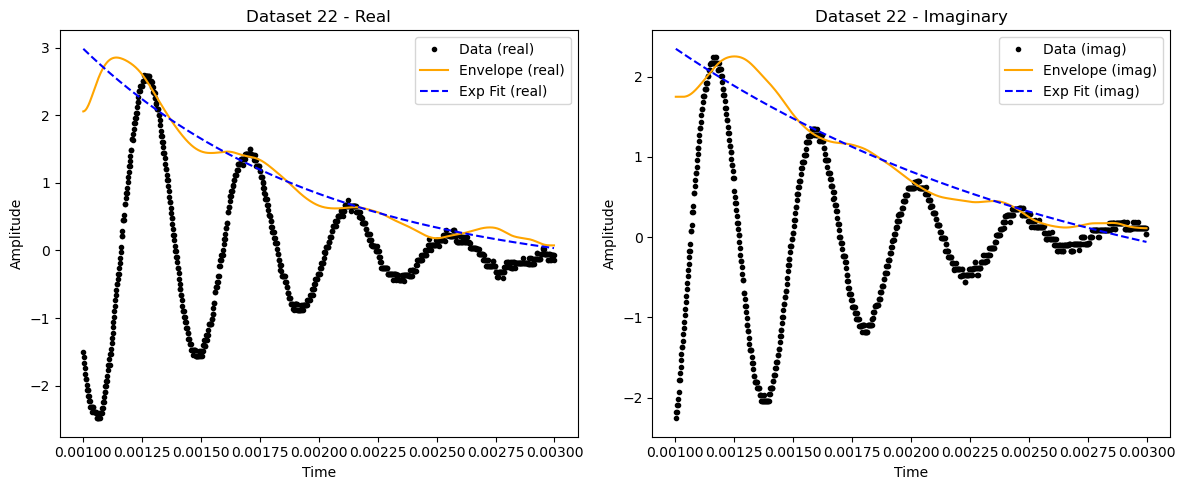

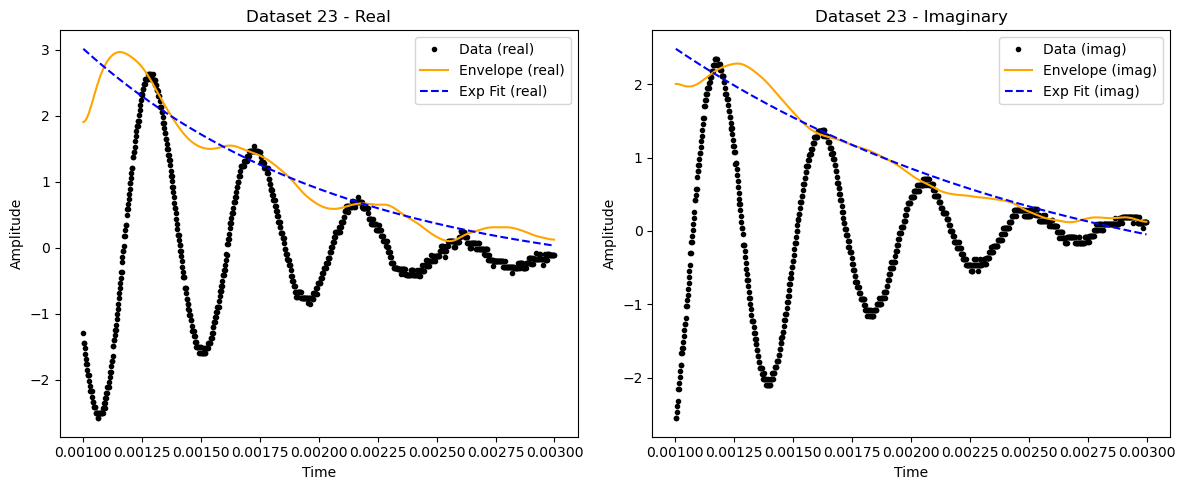

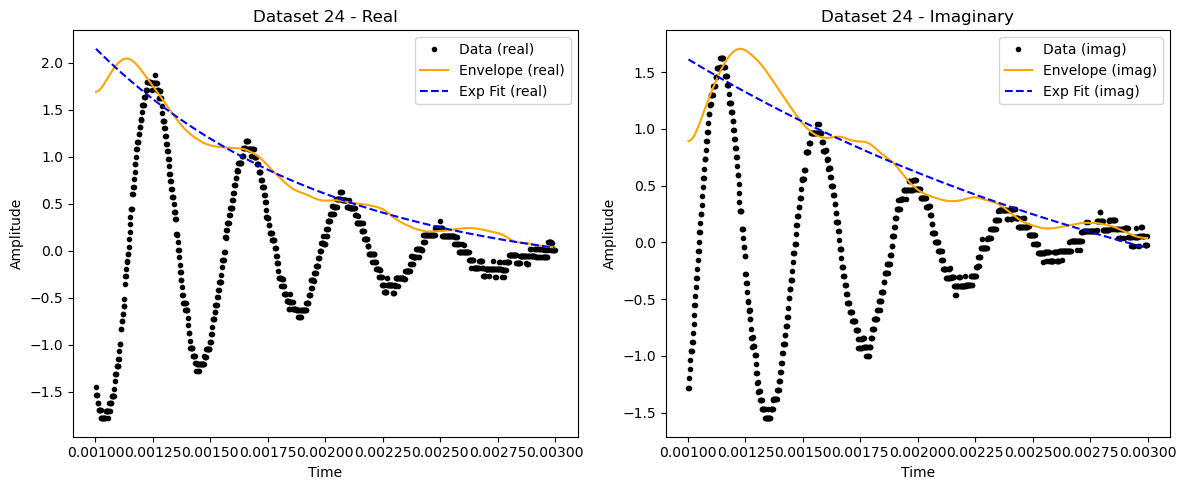

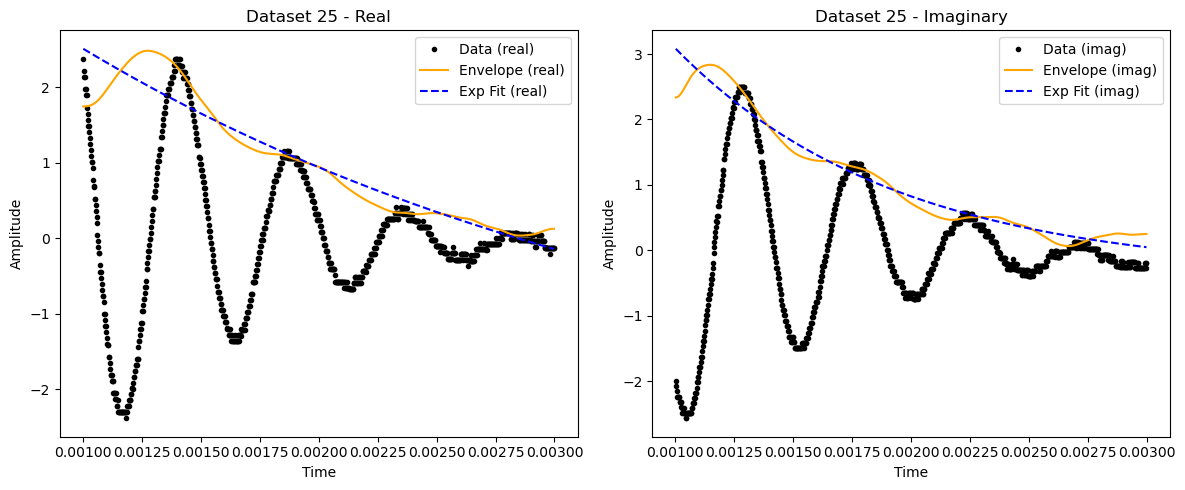

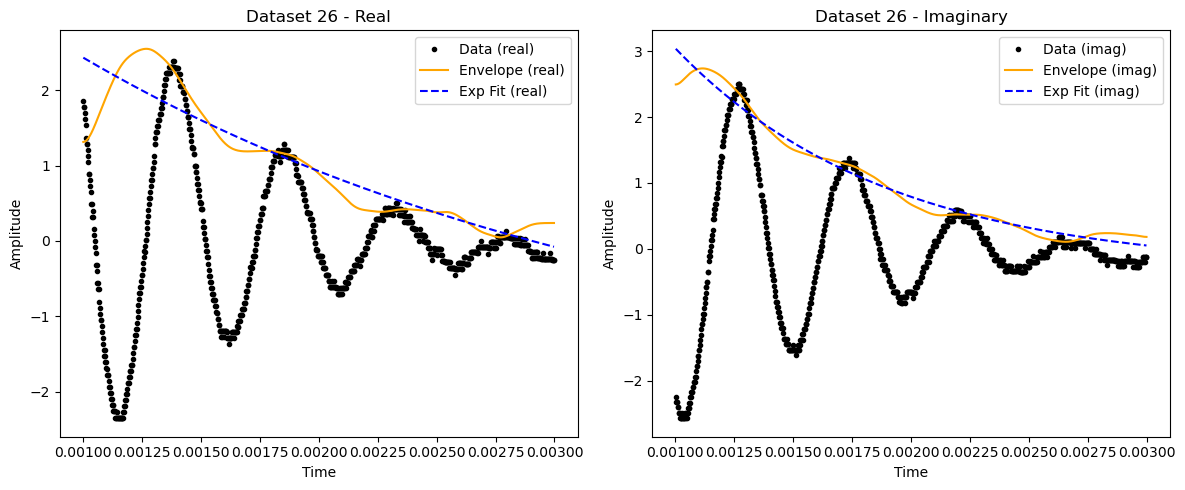

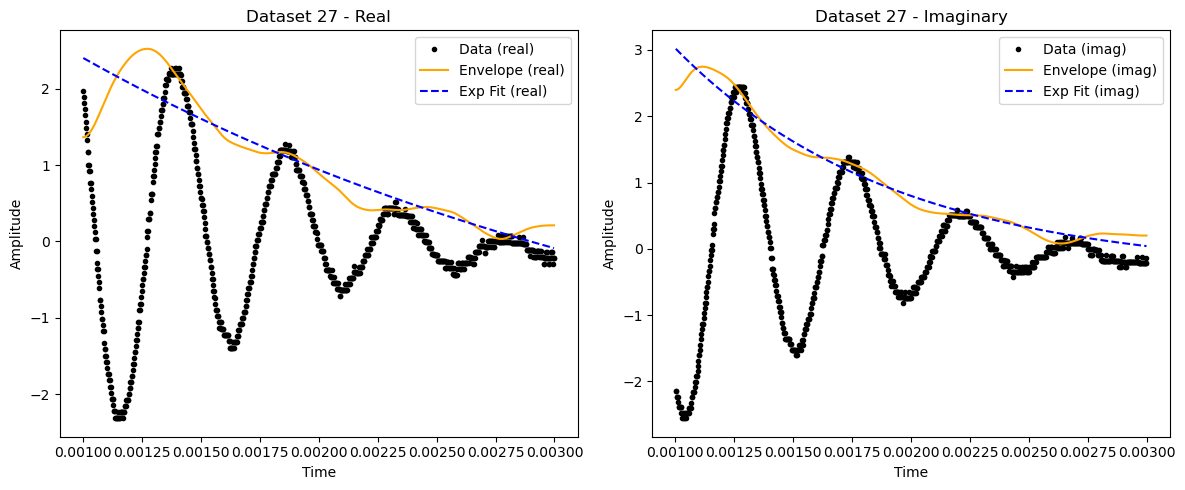

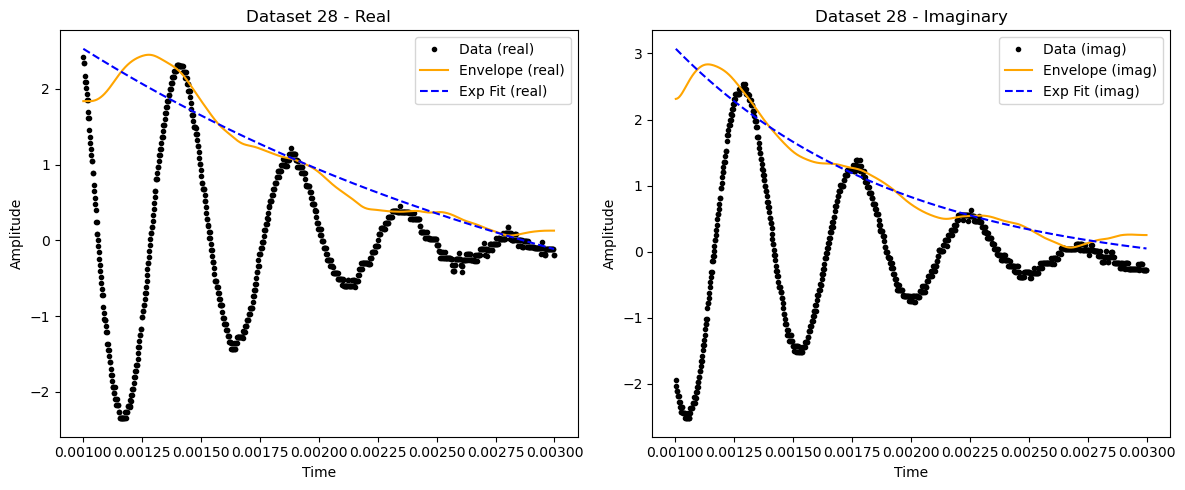

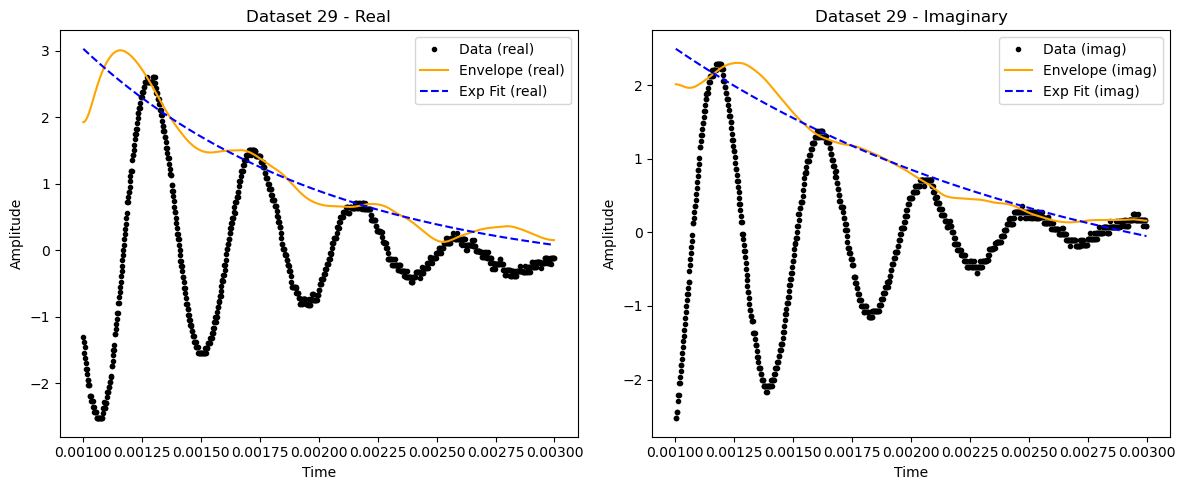

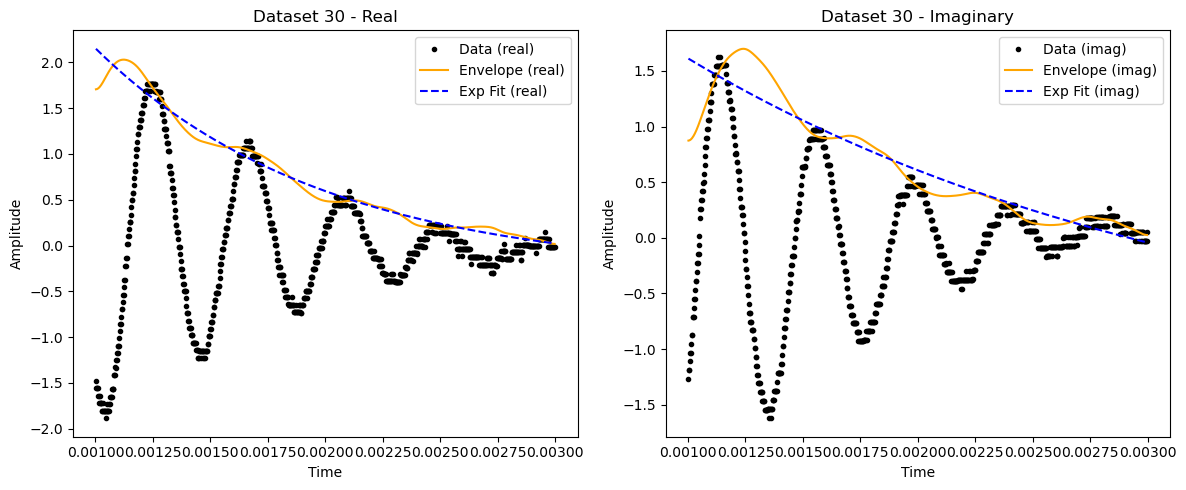

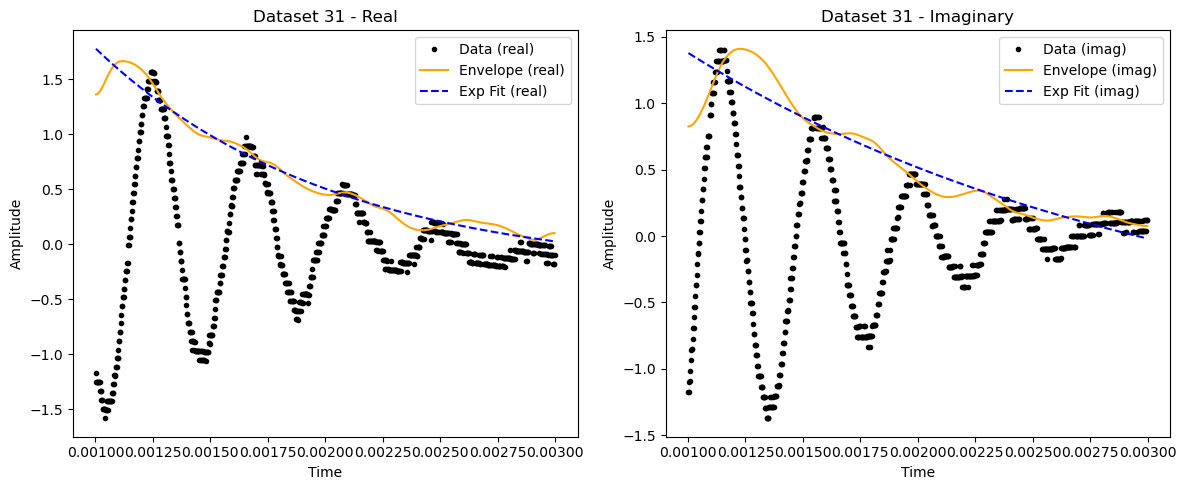

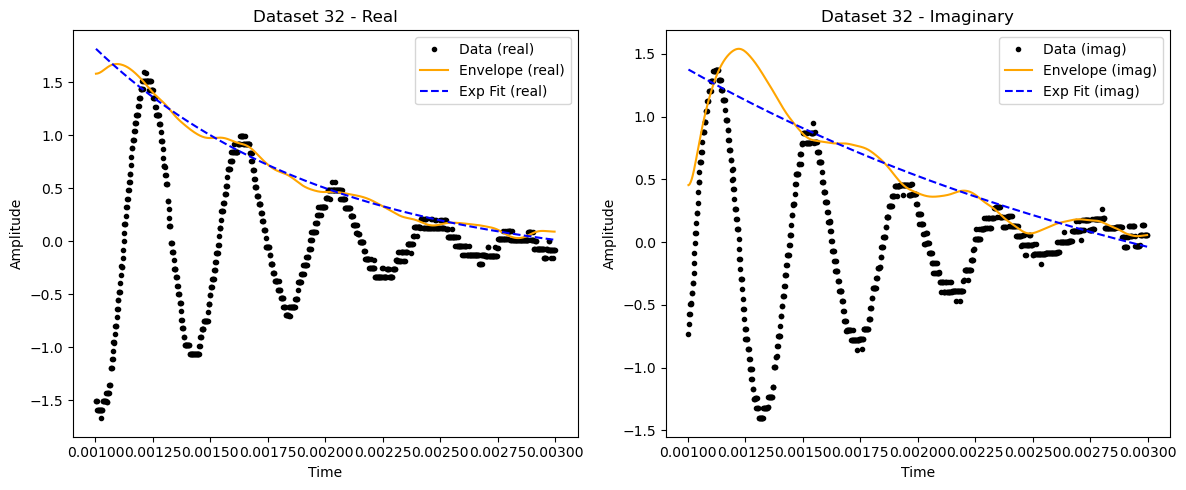

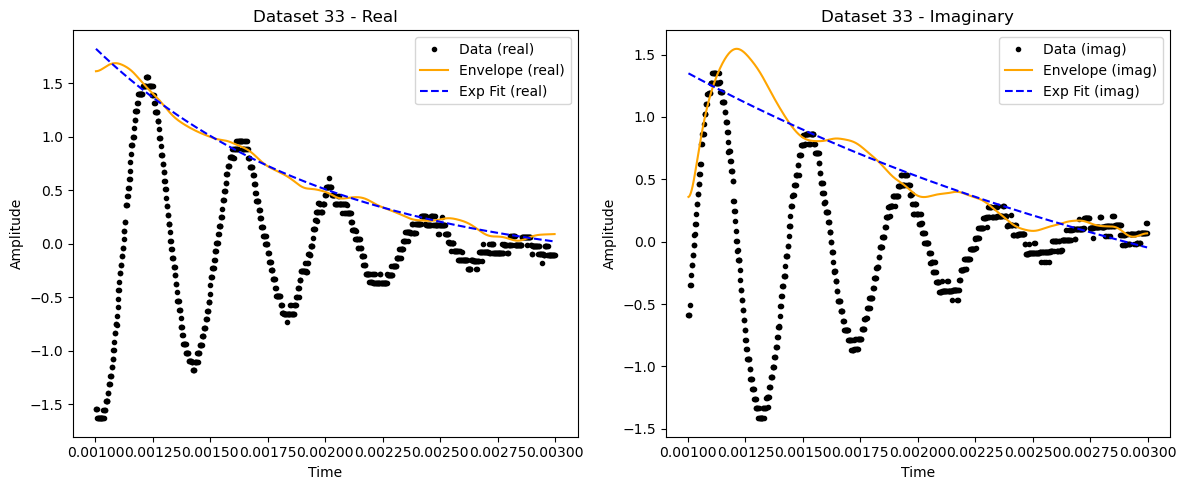

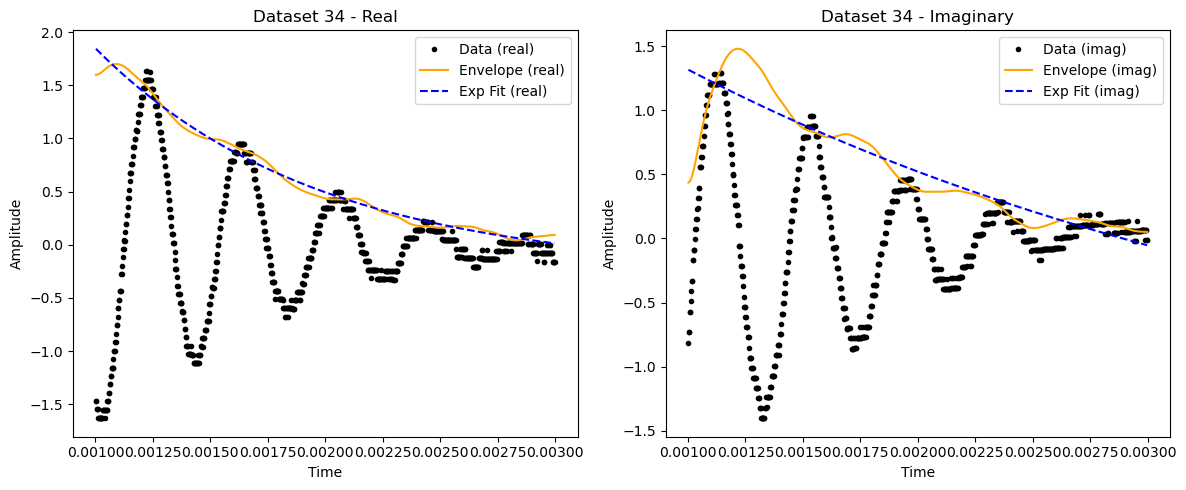

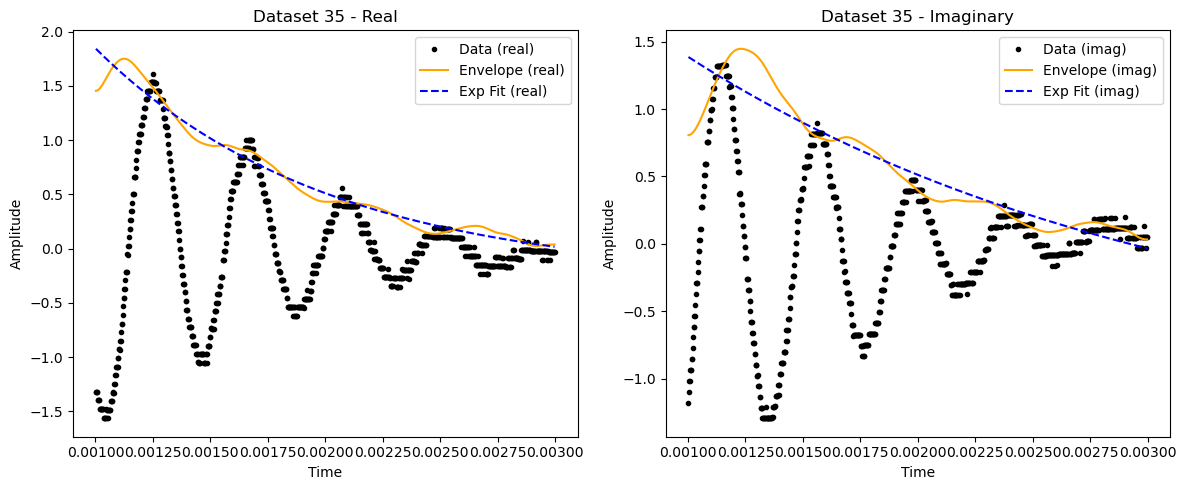

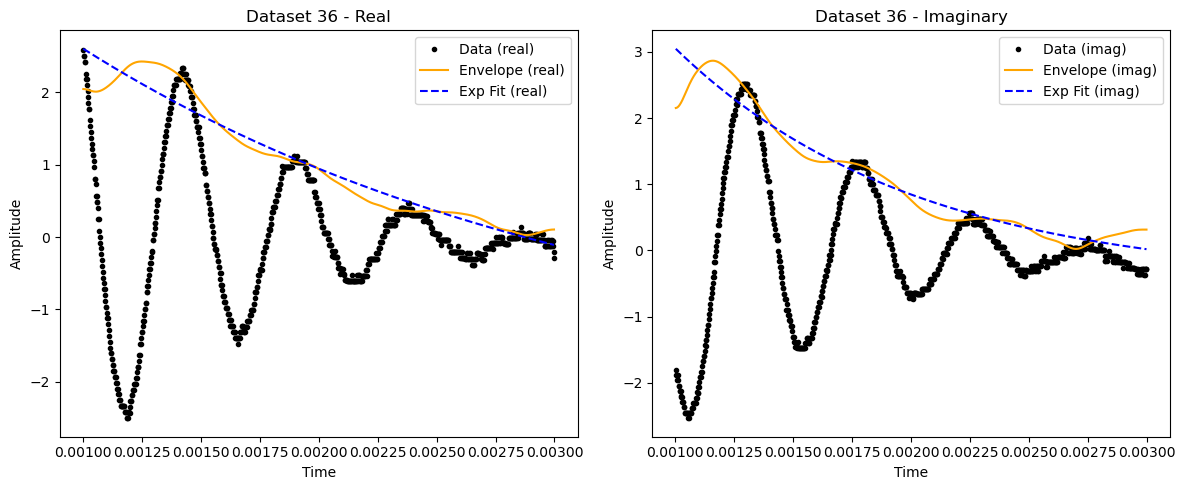

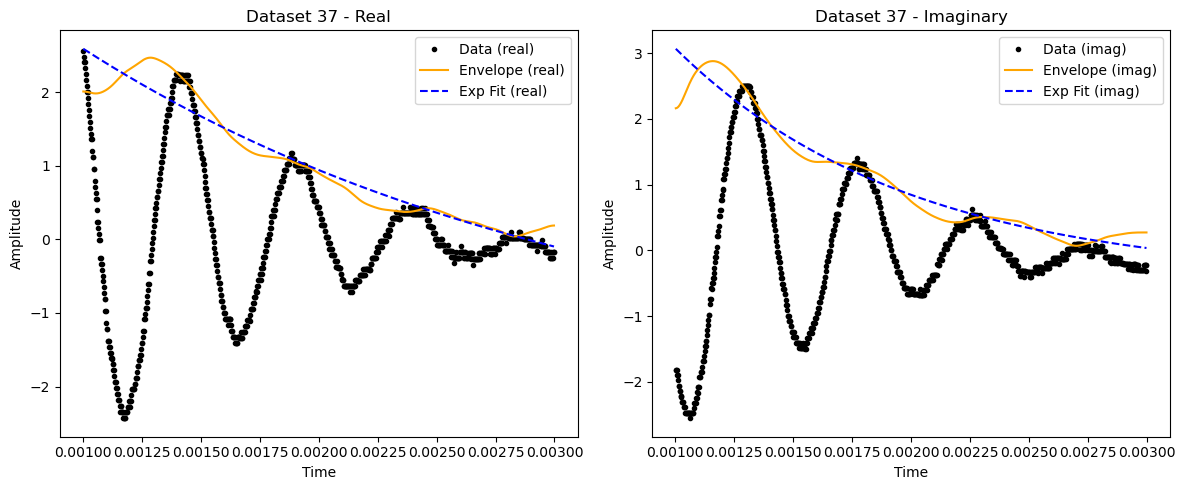

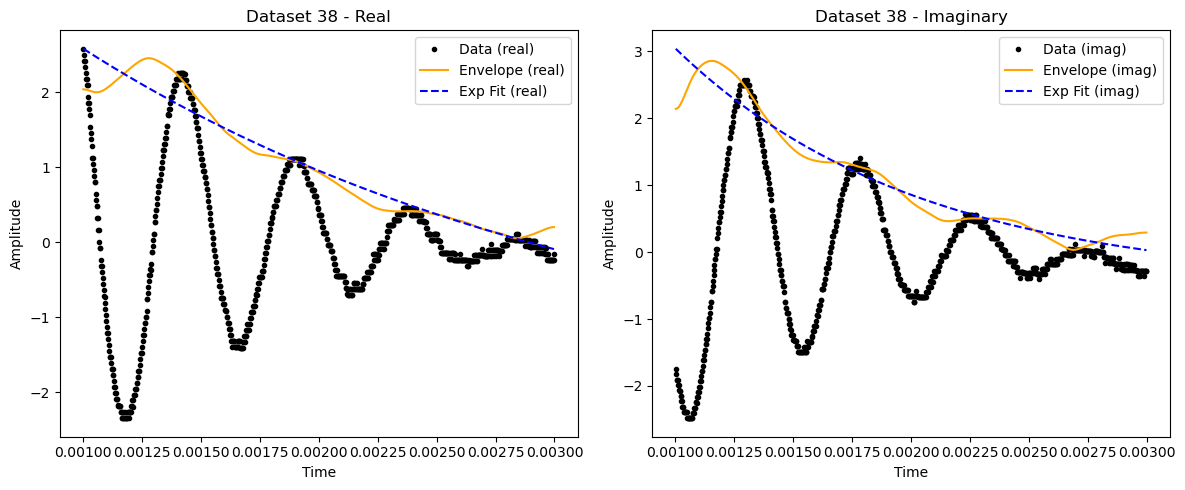

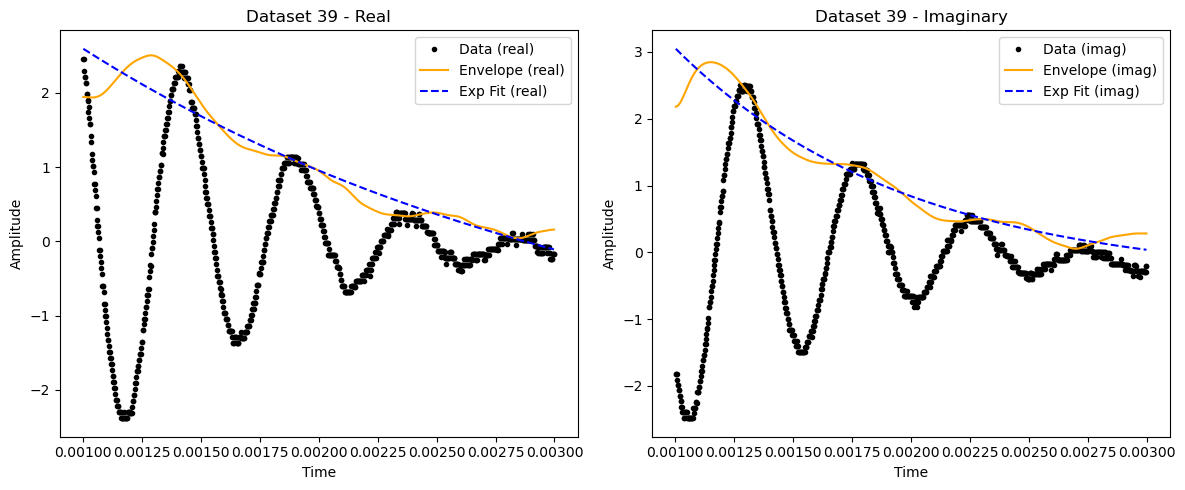

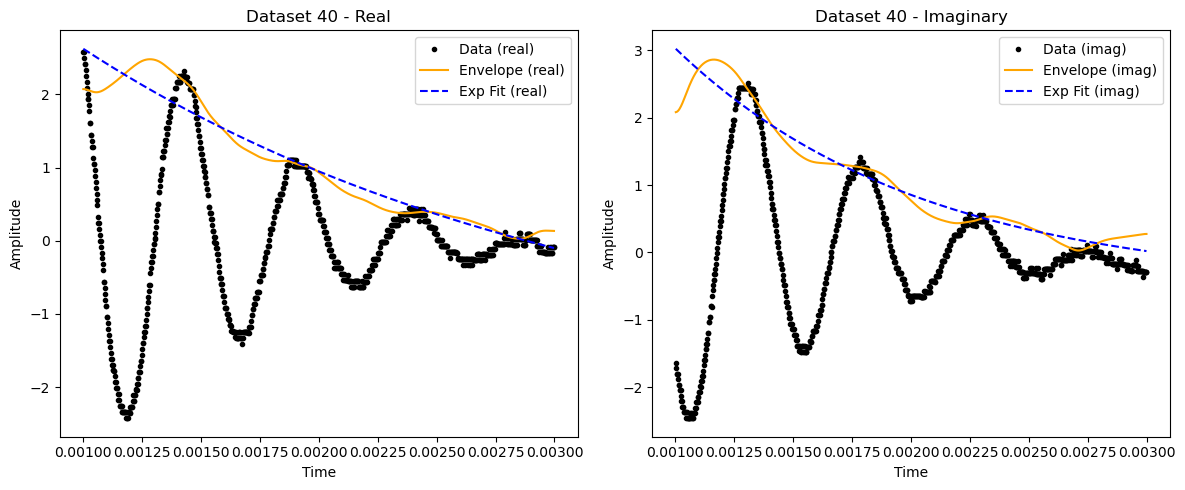

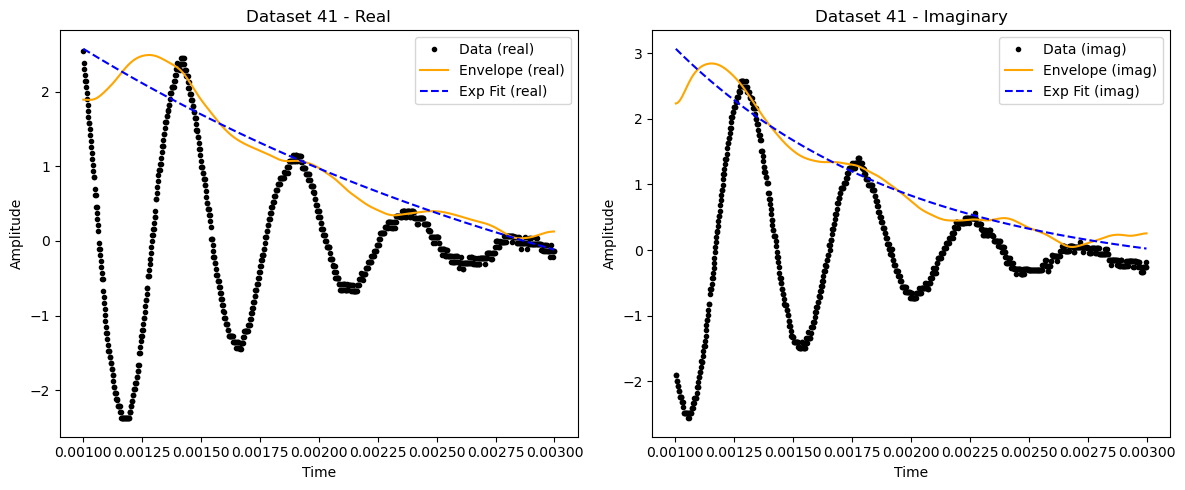

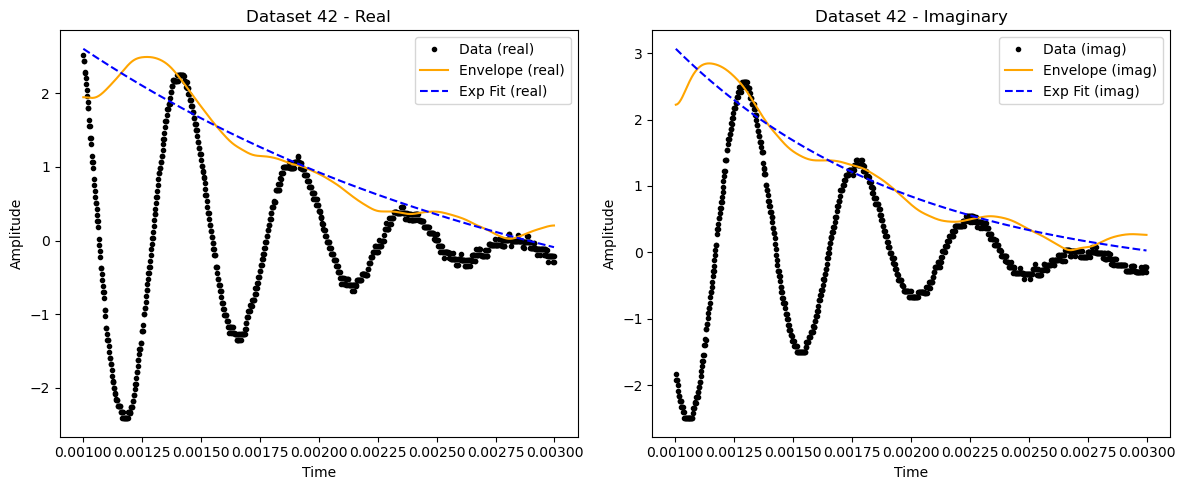

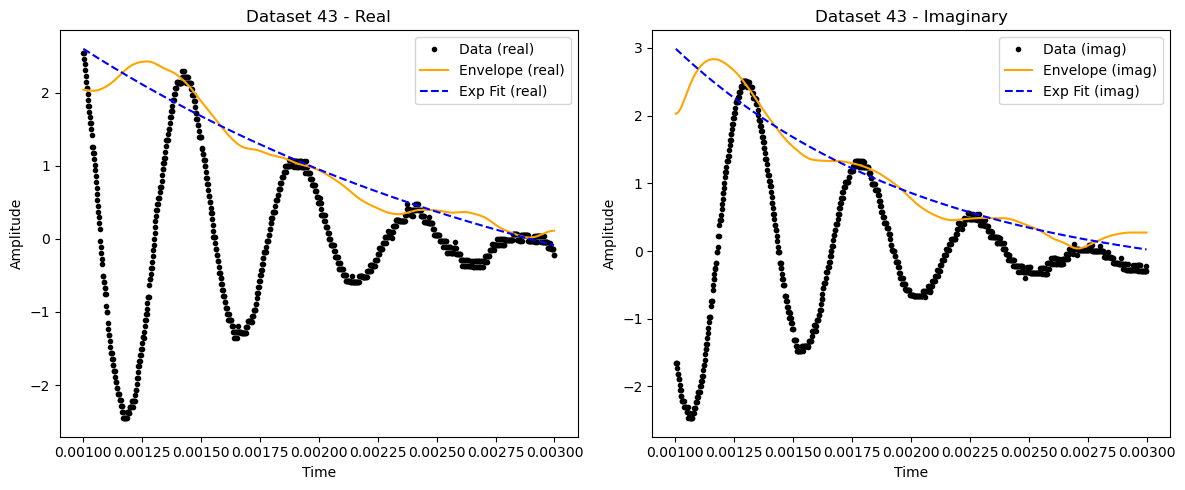

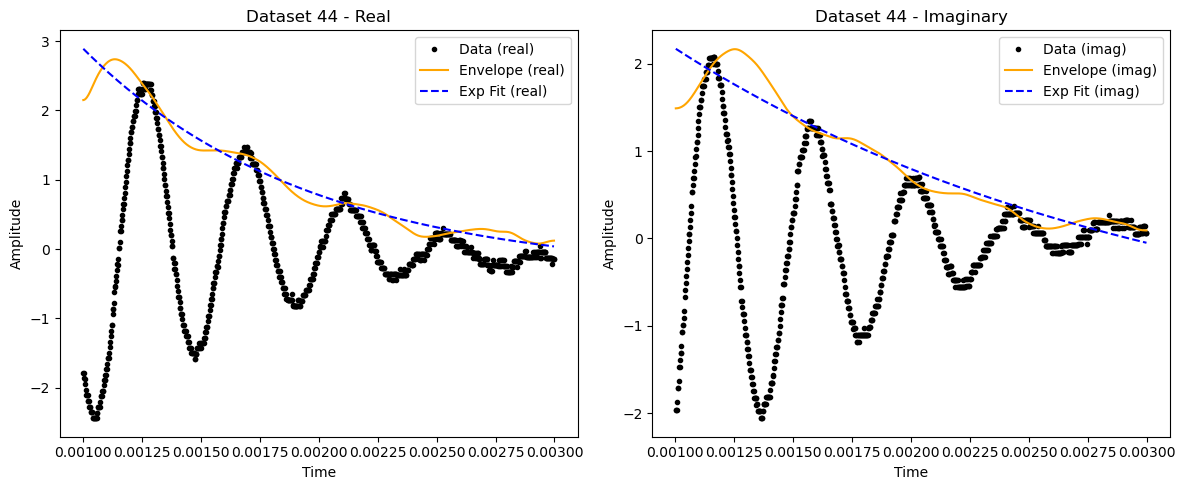

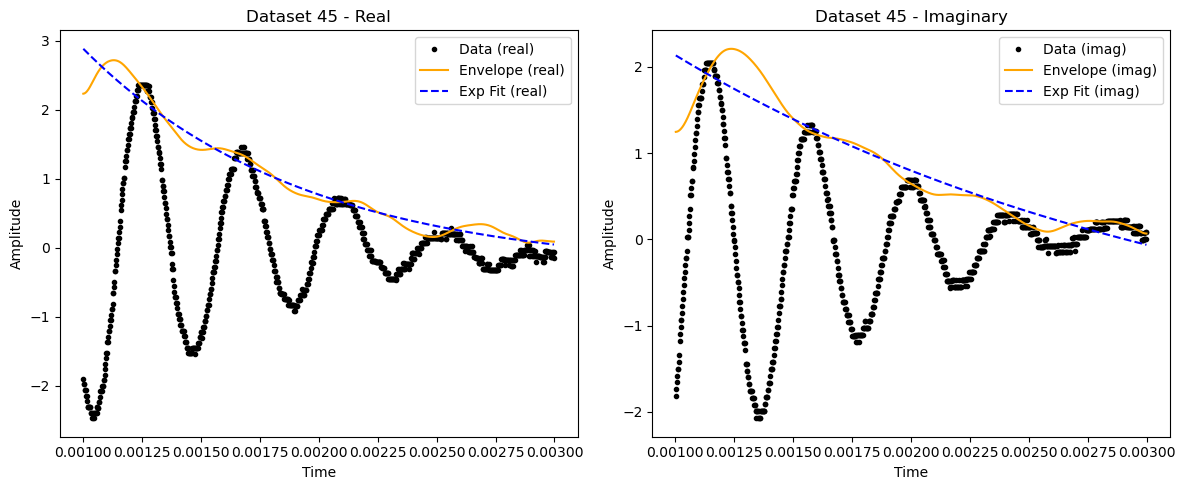

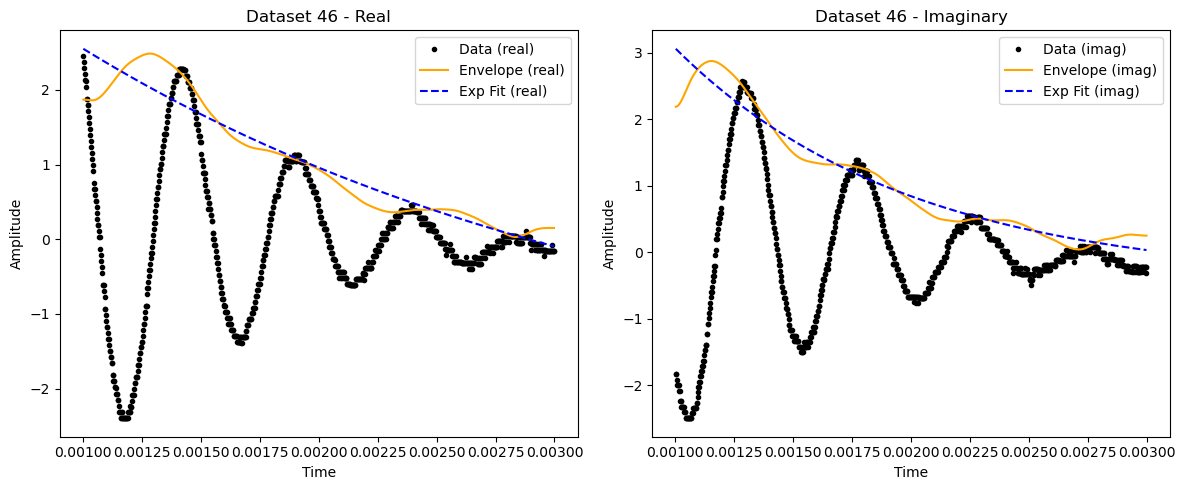

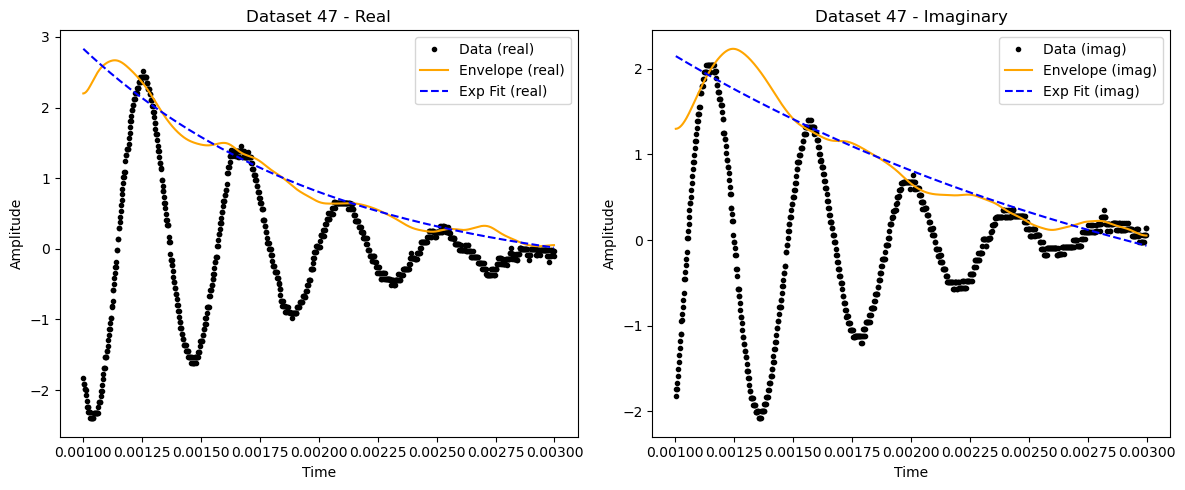

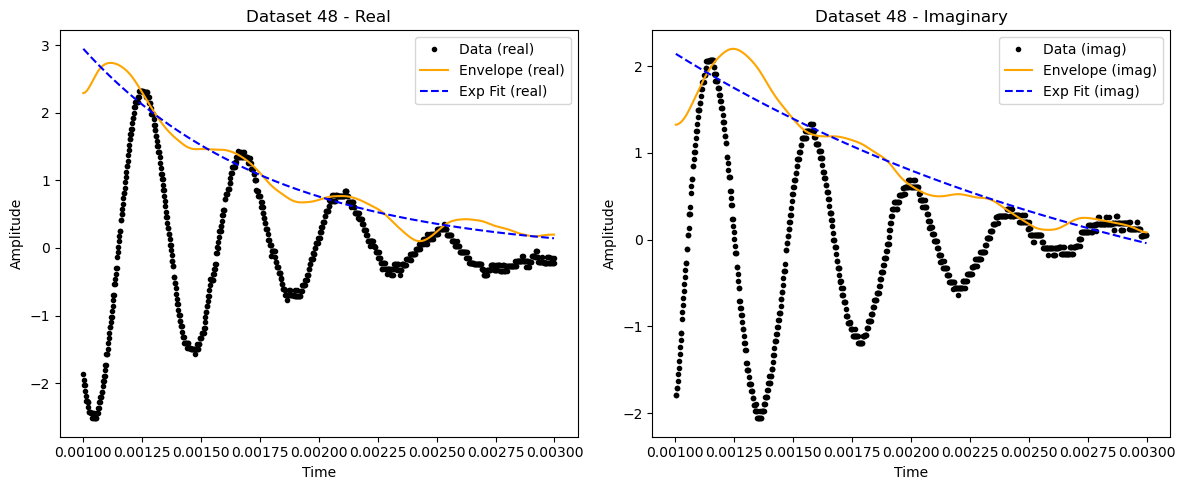

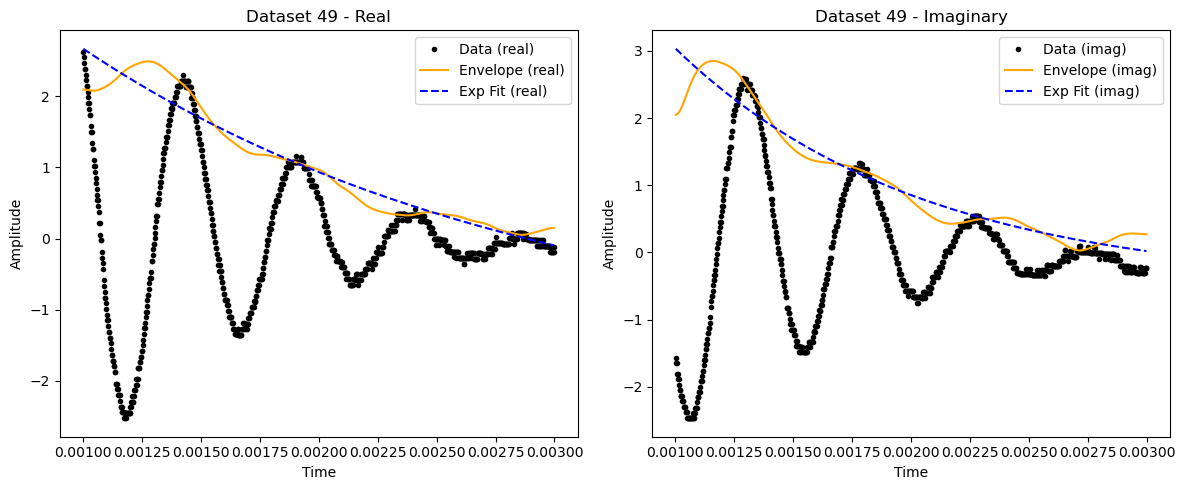

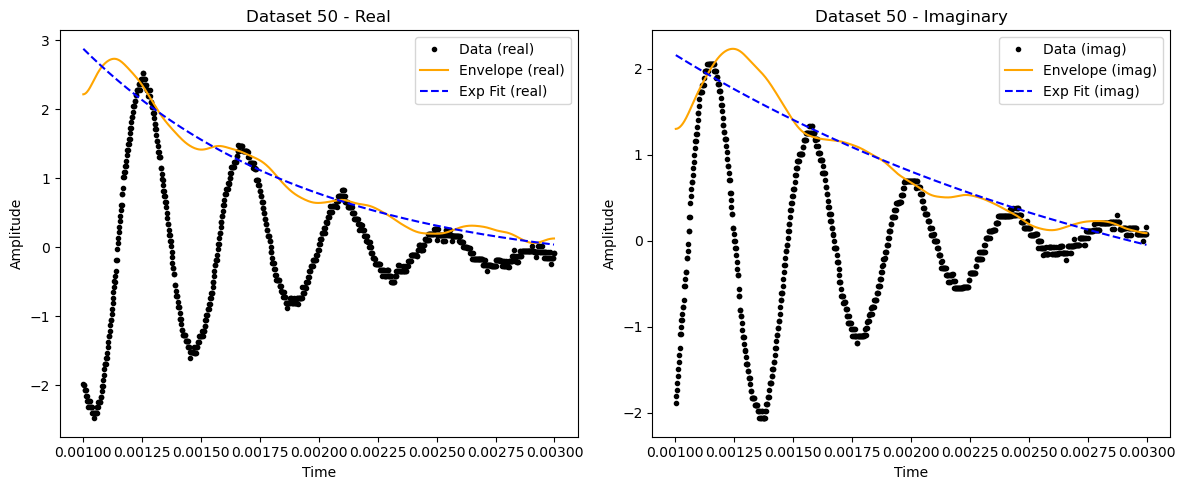

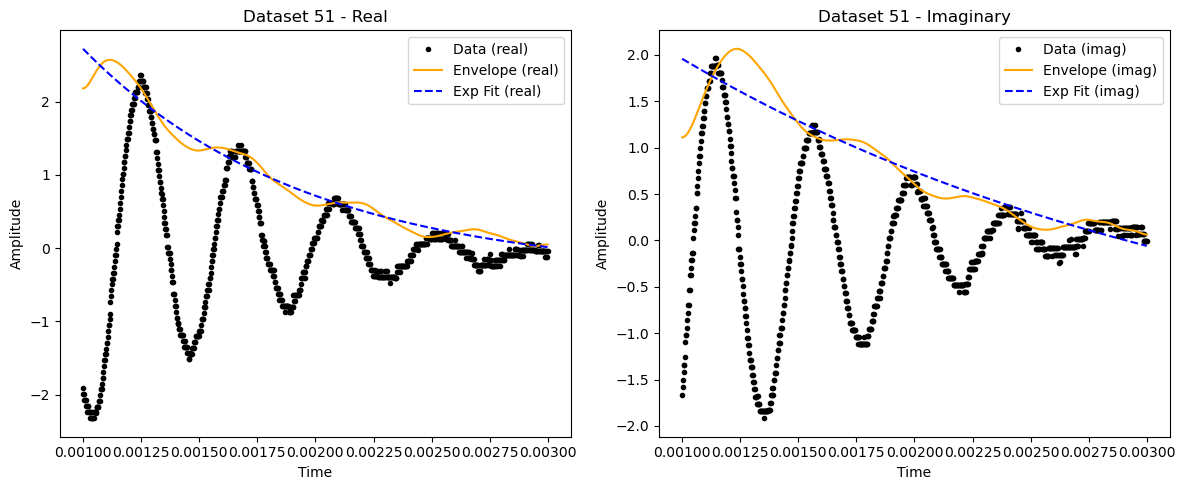

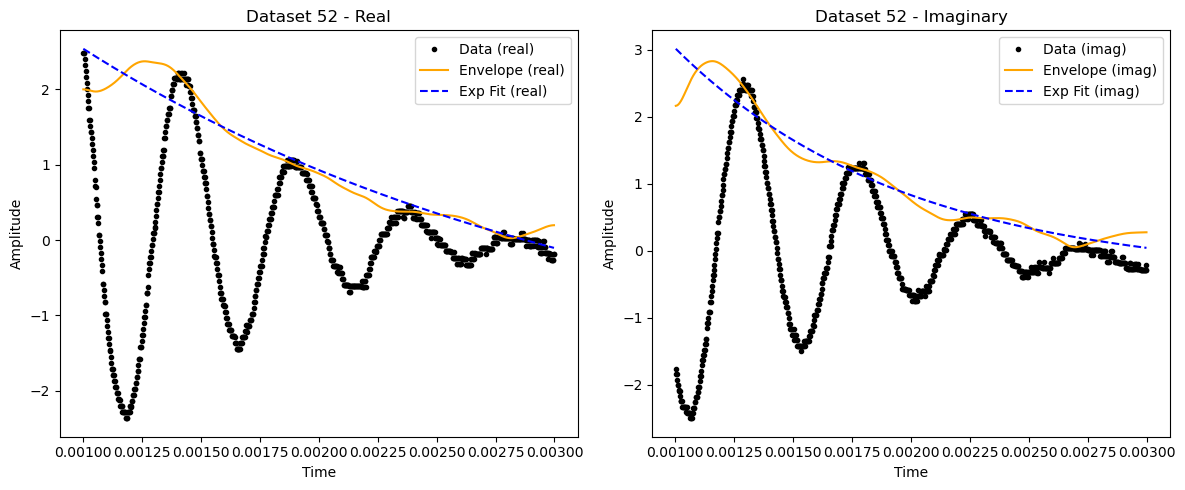

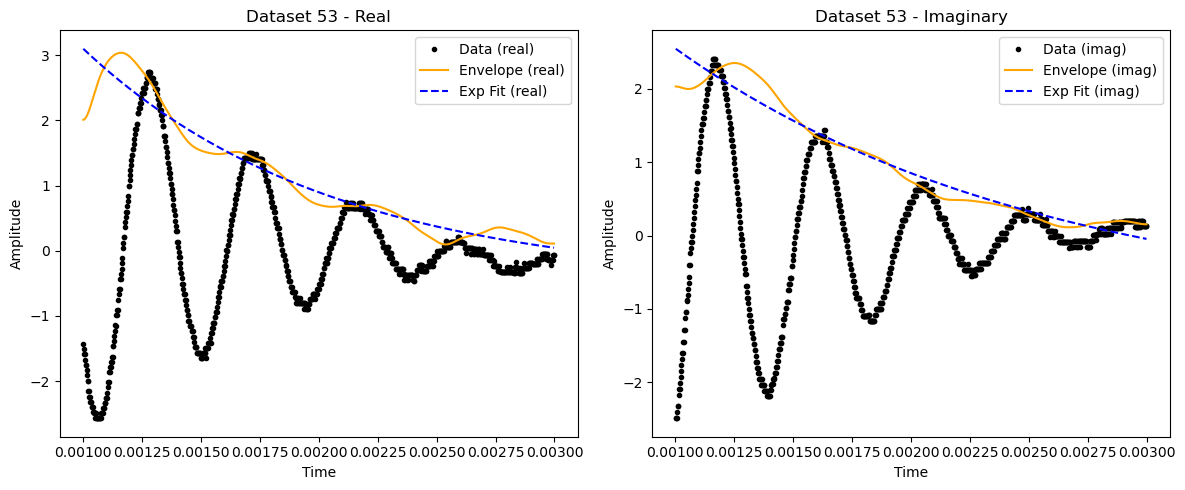

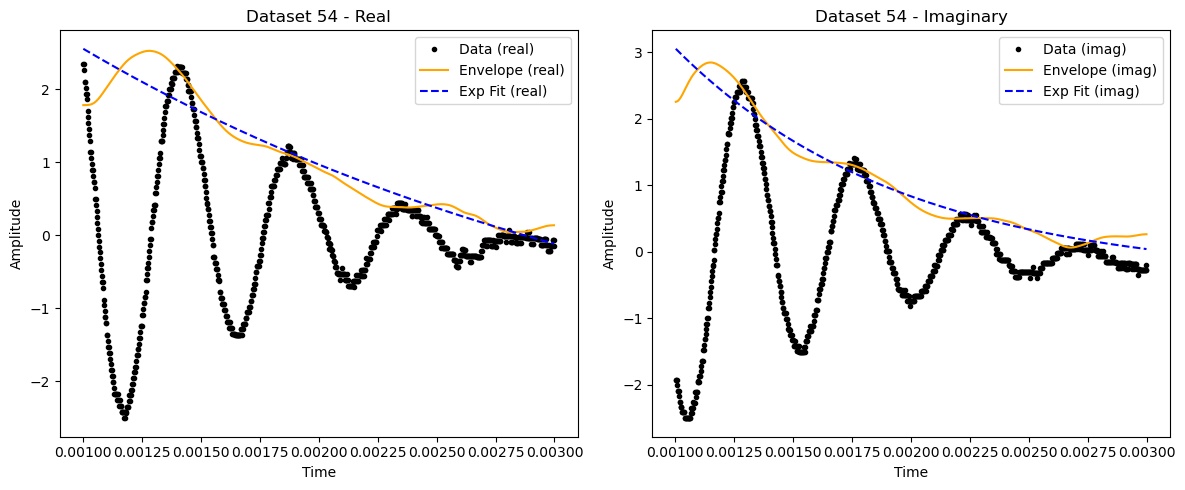

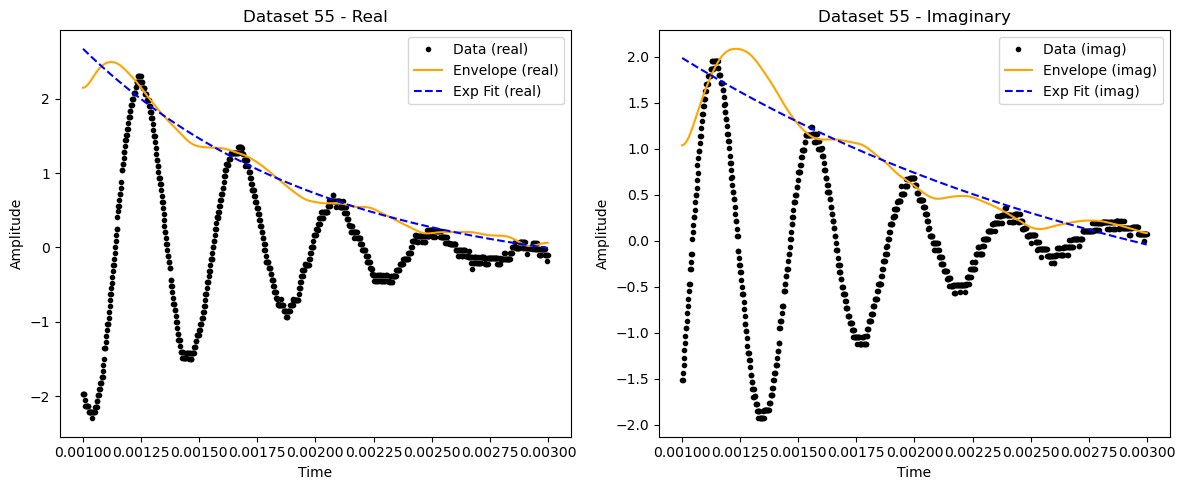

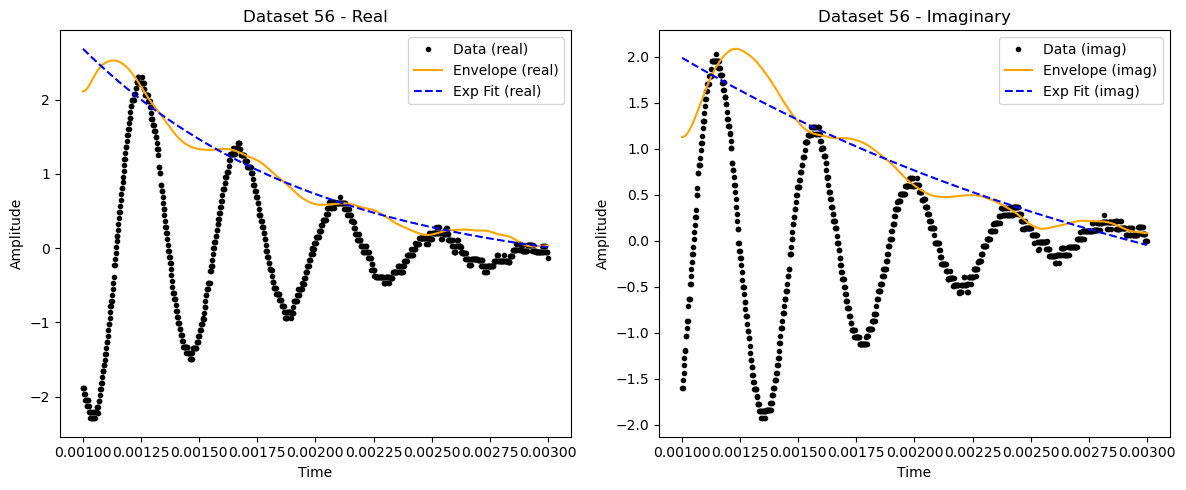

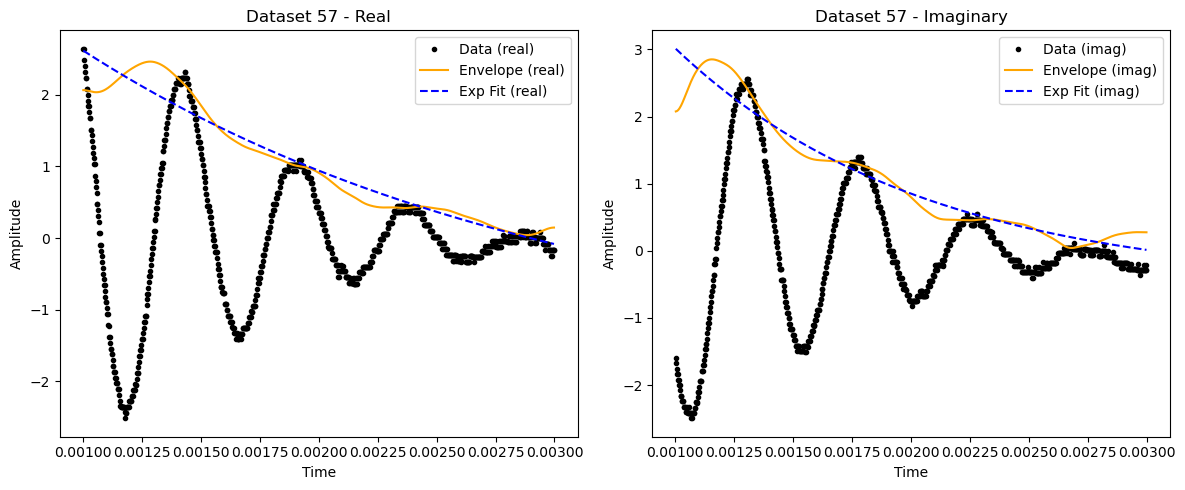

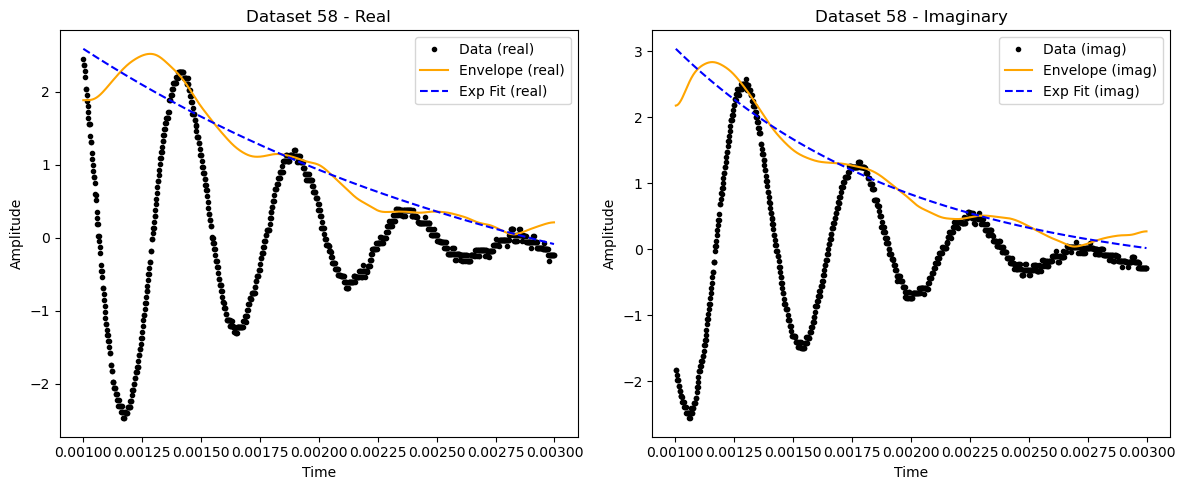

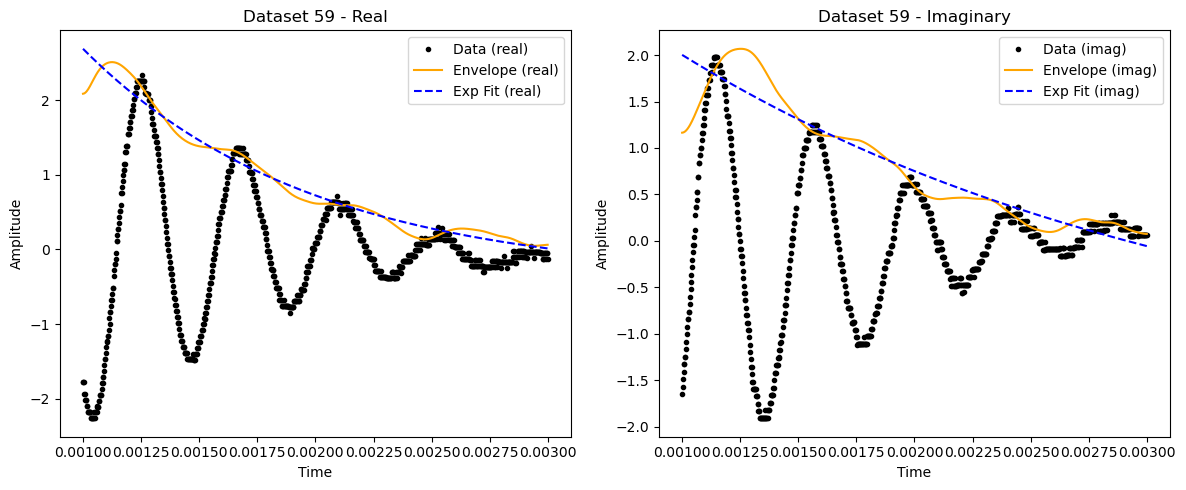

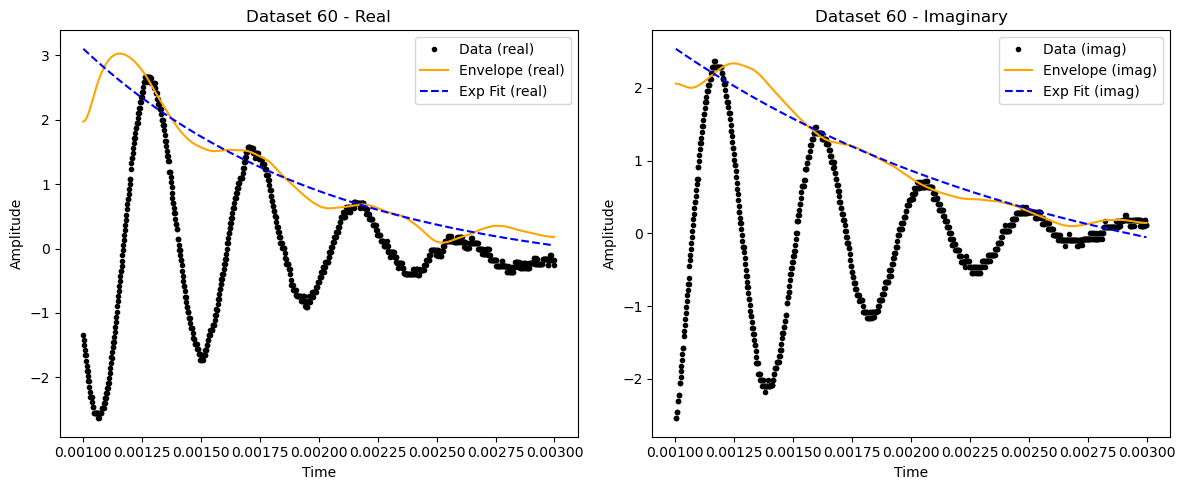

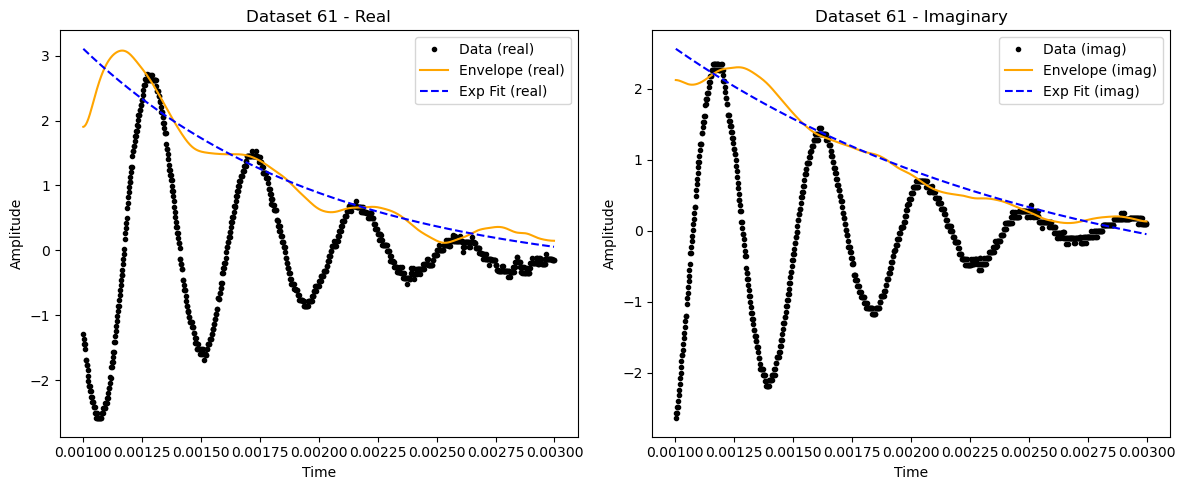

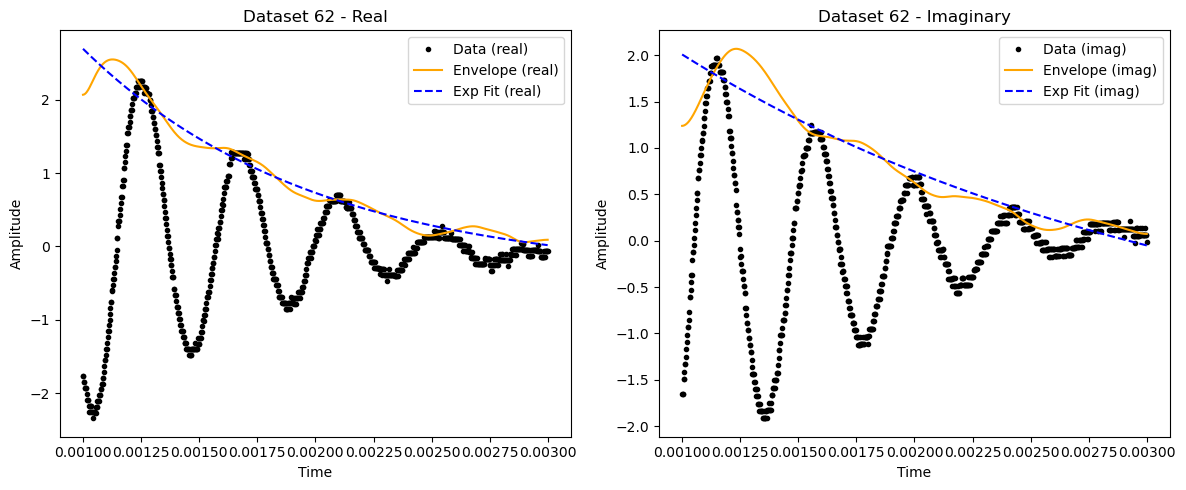

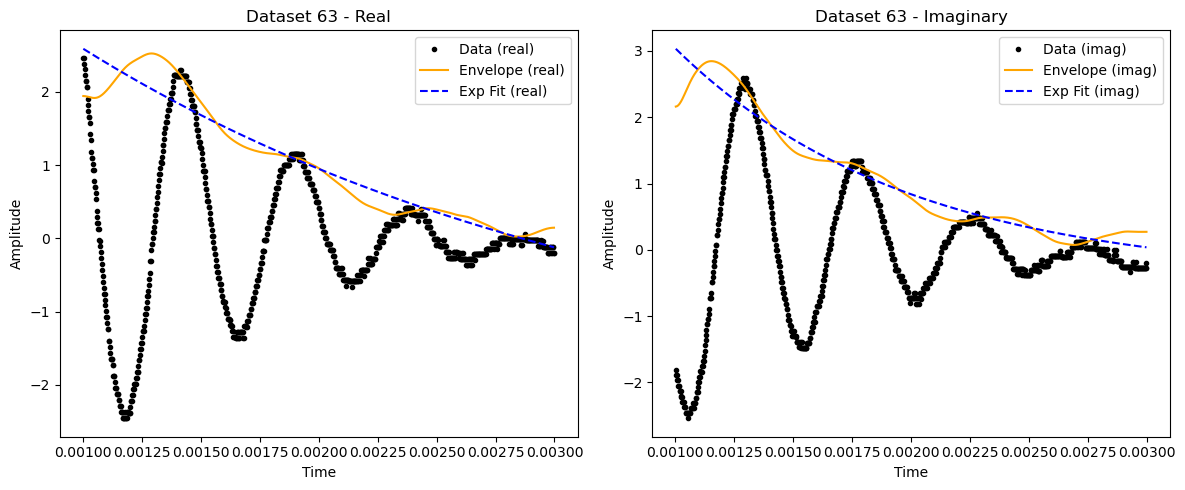

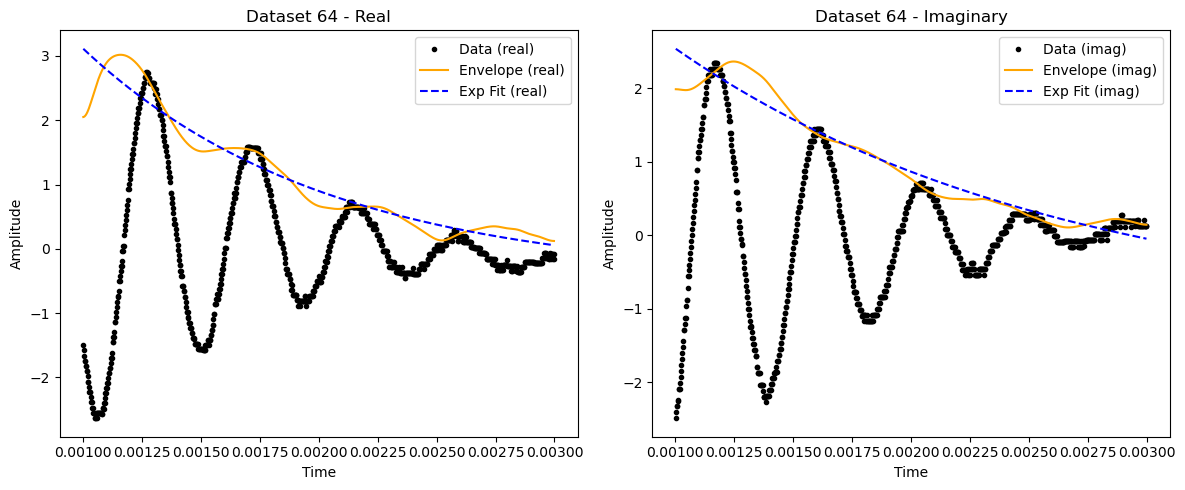

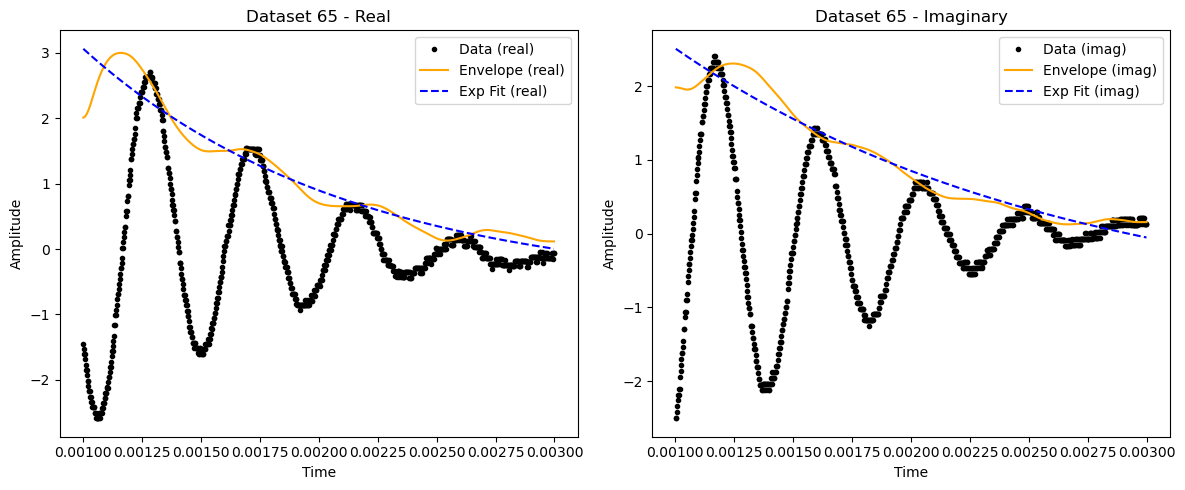

Real T2*:
  Mean T2* = 0.0017 us
  Std = 0.0007
  SEM = 0.0001
  95% CI = ±0.0002

Imaginary T2*:
  Mean T2* = 0.0015 us
  Std = 0.0006
  SEM = 0.0001
  95% CI = ±0.0001



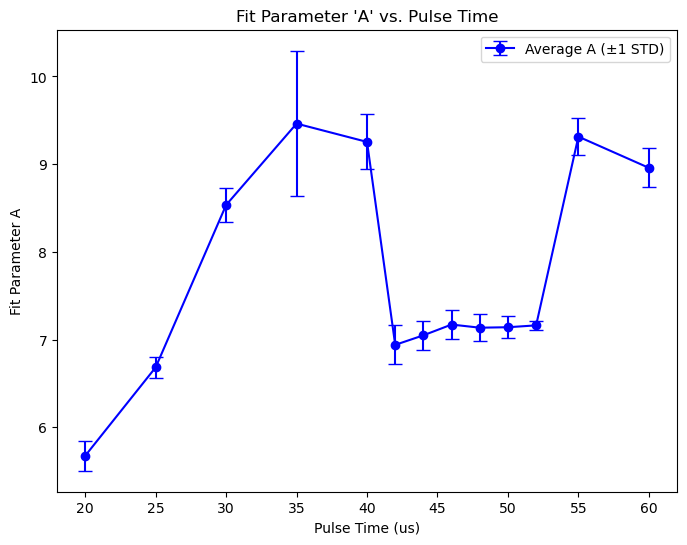

In [7]:
results = []
fits = []

TIME_CUTOFF = 0.003  # 3 ms cutoff for the time axis

# Loop through each dataset
for idx, (df, pulse_time) in enumerate(zip(data, pulse_times)):
    df = df[df['t'] < TIME_CUTOFF]  # Apply time cutoff

    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # Subtract linear fit
    real_signal -= np.polyval(np.polyfit(t, real_signal, 1), t)
    imag_signal -= np.polyval(np.polyfit(t, imag_signal, 1), t)

    # Apply the robust envelope fitting to both real and imaginary channels
    popt_real, env_real = fit_decay_with_envelope(df, channel='CH1')
    popt_imag, env_imag = fit_decay_with_envelope(df, channel='CH2')
    
    # Store results (e.g., the T2* from the exponential fit)
    results.append({
        'Dataset': idx + 1,
        'Pulse Time (us)': pulse_time,
        'Real_T2star': popt_real[1],
        'Imag_T2star': popt_imag[1]
    })

    fits.append((t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag))

# Display summary results
results_df = pd.DataFrame(results)
print(results_df)

# ------------------
# PLOTTING THE FITS FOR EACH DATASET
# ------------------
# Plot the results
for idx, (t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag) in enumerate(fits):
    # Plot Real Channel (CH1)
    plt.figure(figsize=(12, 5))

    # Real part
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'k.', label='Data (real)')
    plt.plot(t, env_real, 'orange', label='Envelope (real)')
    plt.plot(t, model_exp(t, *popt_real), 'b--', label='Exp Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()

    # Imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'k.', label='Data (imag)')
    plt.plot(t, env_imag, 'orange', label='Envelope (imag)')
    plt.plot(t, model_exp(t, *popt_imag), 'b--', label='Exp Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Imaginary')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display summary statistics for T2* (Real and Imaginary)
def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2* = {mean:.4f} us\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

# Summary for Real (CH1) and Imaginary (CH2) T2* values
real_t2star = pd.Series([popt_real[1] for _, _, _, _, _, popt_real, _ in fits])
imag_t2star = pd.Series([popt_imag[1] for _, _, _, _, _, _, popt_imag in fits])

summarize(real_t2star, "Real T2*")
summarize(imag_t2star, "Imaginary T2*")

# ------------------
# PLOTTING THE 'A' FIT PARAMETER VS. PULSE TIME
# ------------------
# Here we use the 'A' parameter from the real-part fit as the scale.
pulse_A = [popt_real[0] for (_, _, _, _, _, popt_real, _) in fits]
df_A = pd.DataFrame({'Pulse Time (us)': pulse_times, 'A': pulse_A})
grouped_A = df_A.groupby('Pulse Time (us)')['A'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(grouped_A['Pulse Time (us)'], grouped_A['mean'], yerr=grouped_A['std'],
             fmt='bo-', capsize=5, label="Average A (±1 STD)")
plt.xlabel('Pulse Time (us)')
plt.ylabel('Fit Parameter A')
plt.title("Fit Parameter 'A' vs. Pulse Time")
plt.legend()
plt.show()